In [1]:
import pandas as pd
import mplfinance as mpf
import numpy as np
# evaluate a perceptron model on the dataset
from numpy import mean
from numpy import std
from gplearn.genetic import SymbolicRegressor
from sympy import *
from collections import Counter
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,balanced_accuracy_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rcParams
from cycler import cycler
import category_encoders as ce
from sklearn.naive_bayes import GaussianNB,CategoricalNB
from IPython.display import Image
import pgmpy
from sklearn.feature_selection import chi2
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


In [2]:
#plots
import plotly.graph_objects as go
import plotly.express as px

#metrics
from sklearn.metrics import roc_curve


In [3]:
#neural network
import tensorflow as tf
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split


# <font color= #6B6B6B> 1. Data Description </font>

Description of datasets and info used, info from april 1st 2021 to end of september 2022, ohlc of prices from binance, BTCUSDT.
for trials a dataset from only august is used, frequency is per minute.

- data obtained from https://data.binance.vision/?prefix=data/spot/monthly/klines/BTCUSDT/1m/

In [4]:
#data = pd.read_parquet('ohlcV.parquet')
#data = pd.read_parquet('ohlc-2017.parquet')
#data = pd.read_parquet('ohlc-2021.parquet')
data = pd.read_parquet('ohlc1.parquet')
data = data.drop(['drop', 'close_time'], axis=1)
data.head()

open      high       low     close     volume  \
timestamp                                                                
2022-08-01 00:00:00  23296.36  23296.78  23262.27  23280.77  202.57486   
2022-08-01 00:01:00  23280.77  23317.68  23263.01  23313.09  153.76413   
2022-08-01 00:02:00  23316.78  23317.72  23271.23  23287.89  119.87883   
2022-08-01 00:03:00  23287.89  23291.08  23263.02  23278.59  100.59952   
2022-08-01 00:04:00  23275.48  23297.48  23266.27  23277.42   74.75517   

                     quote_asset_volume  trades  buy_asset_volume  \
timestamp                                                           
2022-08-01 00:00:00        4.715691e+06    5988          98.30337   
2022-08-01 00:01:00        3.580741e+06    5474          83.70472   
2022-08-01 00:02:00        2.792681e+06    4154          48.58543   
2022-08-01 00:03:00        2.341383e+06    4169          50.14998   
2022-08-01 00:04:00        1.740367e+06    3539          37.88062   

                     taker_buy_asset_volume  
timestamp                                    
2022-08-01 00:00:00            2.288439e+06  
2022-08-01 00:01:00            1.949636e+06  
2022-08-01 00:02:00            1.131939e+06  
2022-08-01 00:03:00            1.167198e+06  
2022-08-01 00:04:00            8.819088e+05

In [5]:
data.shape

(44640, 9)

In [6]:
data.isnull().sum()

open                      0
high                      0
low                       0
close                     0
volume                    0
quote_asset_volume        0
trades                    0
buy_asset_volume          0
taker_buy_asset_volume    0
dtype: int64

In [7]:
#%% Quick description of the data
desc = data.describe()
info = data.info()
print(desc,info)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44640 entries, 2022-08-01 00:00:00 to 2022-08-31 23:59:00
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open                    44640 non-null  float64
 1   high                    44640 non-null  float64
 2   low                     44640 non-null  float64
 3   close                   44640 non-null  float64
 4   volume                  44640 non-null  float64
 5   quote_asset_volume      44640 non-null  float64
 6   trades                  44640 non-null  int64  
 7   buy_asset_volume        44640 non-null  float64
 8   taker_buy_asset_volume  44640 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 3.4 MB
               open          high           low         close        volume  \
count  44640.000000  44640.000000  44640.000000  44640.000000  44640.000000   
mean   22470.411851  22481.868341  22458.947005  22470.333063    1

<function matplotlib.pyplot.show(close=None, block=None)>

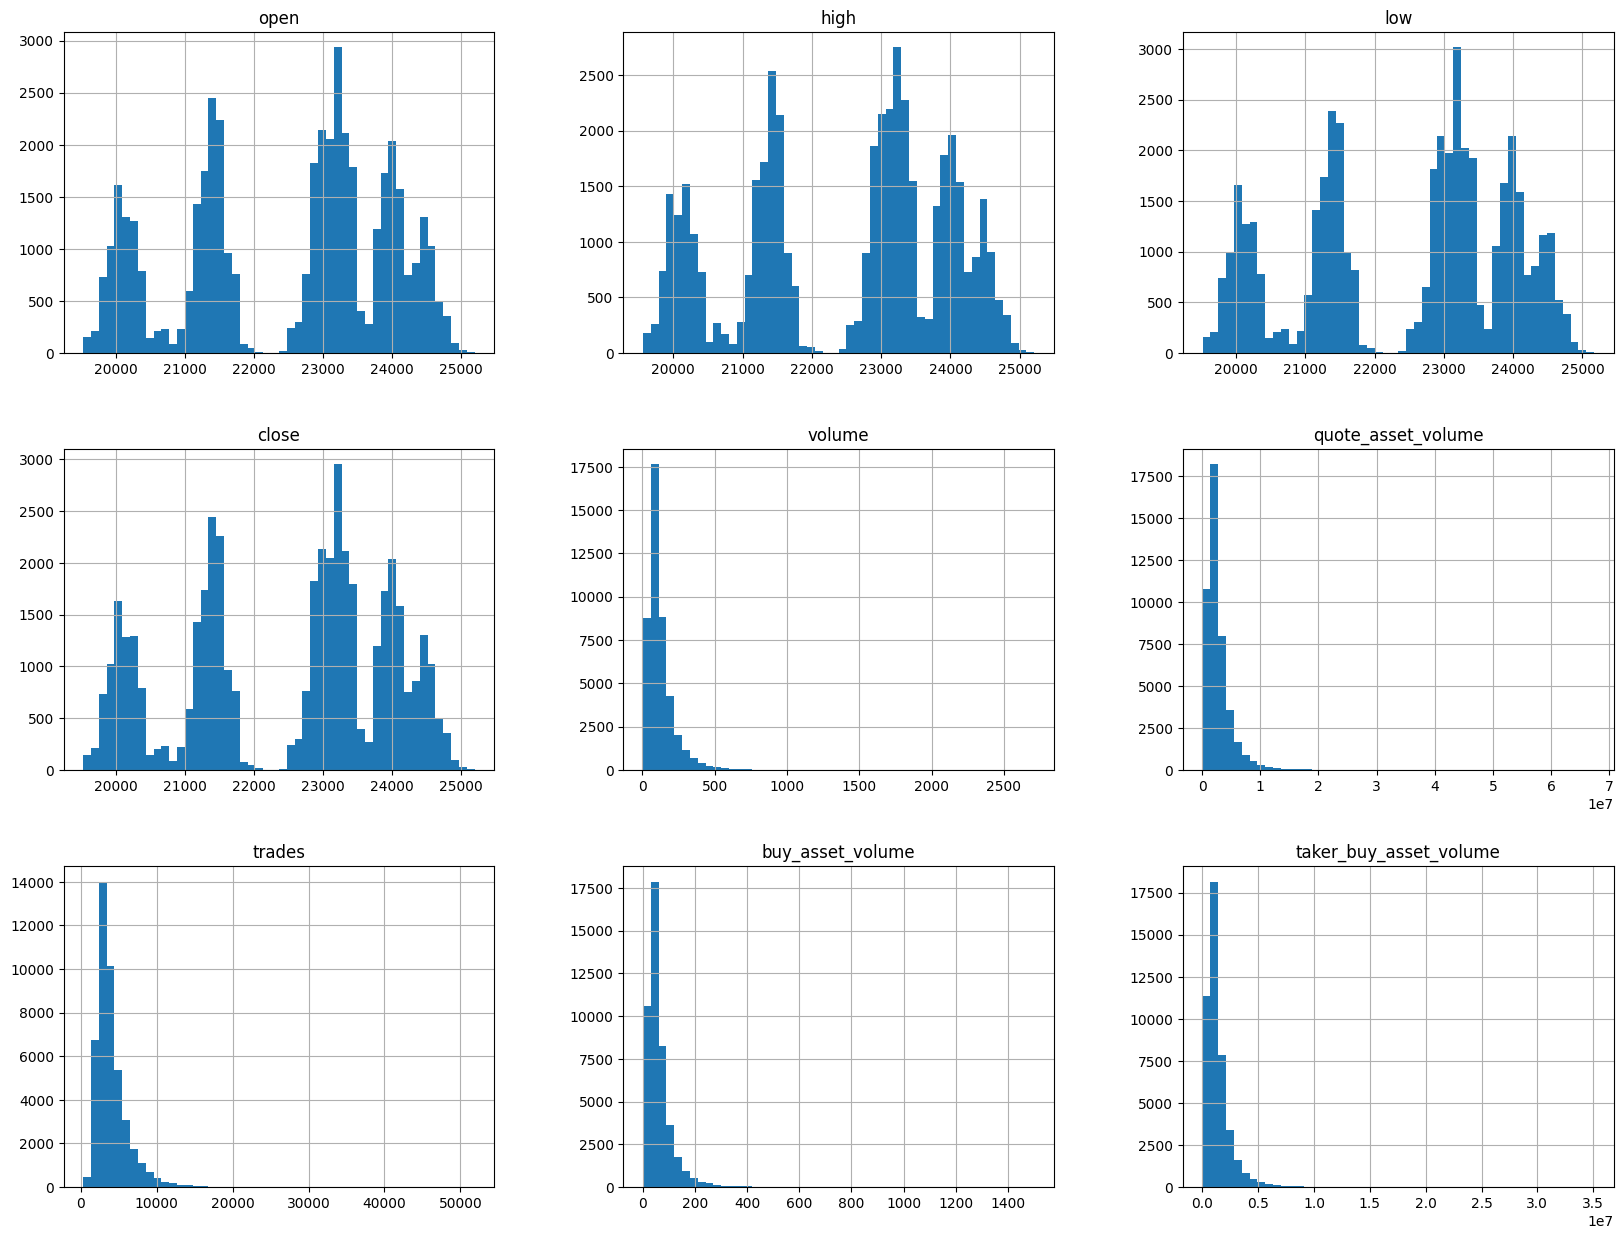

In [8]:
%matplotlib inline
data.hist(bins=50,figsize=(20,15))
plt.show

<AxesSubplot:xlabel='timestamp'>

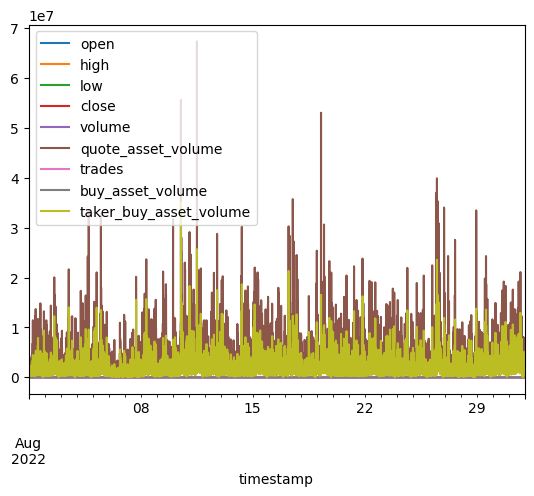

In [9]:
data.plot()

Description of variables:

- Timestamp = time series serving as index, it goes in intervals of 1 minute, from the beggining of 2022, until the end of august.

OHLC variables , this are numeric , based on the prices of the cross between BTC and USDT
- Open is a numeric variable, expressing the first price, at the beginning of the epoch.
- High is a numeric variable, expressing the max value of the epoch.
- Low is the variable expressing the min value of the epoch observed.
- Close is the last value of the epoch.

Volume variables, numeric serve as the total quantity observed on the epoch.

Next we do a resampling, to transform the series from micro time to intra day , the period chosen was 1 hour

In [10]:
rs = '5min'
data1 = data.copy()
data1['open'] = data1['open'].resample(rs).first()
data1['high'] = data1['high'].resample(rs).max()
data1['low'] = data1['low'].resample(rs).min()
data1['close'] = data1['close'].resample(rs).last()
data1['volume'] = data1['volume'].resample(rs).sum()
data1['quote_asset_volume'] = data1['quote_asset_volume'].resample(rs).sum()
data1['trades'] = data1['trades'].resample(rs).sum()
data1['buy_asset_volume'] = data1['buy_asset_volume'].resample(rs).sum()
data1['taker_buy_asset_volume'] = data1['taker_buy_asset_volume'].resample(rs).sum()
data1 =data1.resample(rs).sum()
data1.head()

open      high       low     close     volume  \
timestamp                                                                
2022-08-01 00:00:00  23296.36  23317.72  23262.27  23277.42  651.57251   
2022-08-01 00:05:00  23274.75  23285.84  23257.37  23277.32  474.05582   
2022-08-01 00:10:00  23277.32  23314.99  23272.23  23281.41  406.89184   
2022-08-01 00:15:00  23279.80  23339.05  23265.11  23290.96  673.13135   
2022-08-01 00:20:00  23290.96  23325.00  23276.19  23318.44  260.18358   

                     quote_asset_volume   trades  buy_asset_volume  \
timestamp                                                            
2022-08-01 00:00:00        1.517086e+07  23324.0         318.62412   
2022-08-01 00:05:00        1.103164e+07  16272.0         264.80491   
2022-08-01 00:10:00        9.477077e+06  15735.0         204.50332   
2022-08-01 00:15:00        1.568285e+07  21411.0         362.78386   
2022-08-01 00:20:00        6.061557e+06  12222.0         138.73493   

                     taker_buy_asset_volume  
timestamp                                    
2022-08-01 00:00:00            7.419120e+06  
2022-08-01 00:05:00            6.162329e+06  
2022-08-01 00:10:00            4.763355e+06  
2022-08-01 00:15:00            8.453137e+06  
2022-08-01 00:20:00            3.232255e+06

In [11]:
data1.shape

(8928, 9)

<AxesSubplot:xlabel='timestamp'>

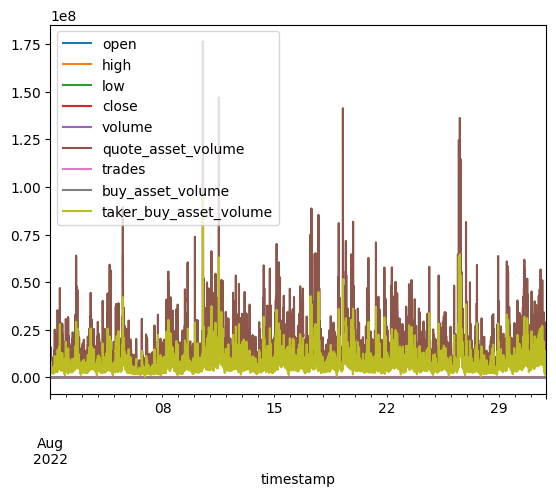

In [12]:
data1.plot()

# <font color= #6B6B6B> 2. Feature Engineering </font>

In [13]:
ohlcv= data1.copy()

In [14]:
# OHLC Chart 
fig = go.Figure(data=go.Ohlc(x=ohlcv.index,
                    open=ohlcv['open'],
                    high=ohlcv['high'],
                    low=ohlcv['low'],
                    close=ohlcv['close']))

fig.show()

#### FEATURES BASIC STATISTICS:
Next we will create the first features based on the OHLCV dataset.
* Volatility(HL):  $ V_t=H_t-L_t$
* High - open(HO): $ HO_t=H_t-O_t$
* Open - low(OL):  $ OL_t=O_t-L_t$
* High - Low(HL):  $ HL_t=H_t-L_t $
* Close - Open(CO): $CO_t=C_t-O_t$


In [15]:
# Volatility
volatility = []
for i in range(len(ohlcv)):
    vol = ohlcv['high'][i] - ohlcv['low'][i]
    volatility.append(vol)
ohlcv['volatility'] = volatility

# micro trends
high_open = []
for i in range(len(ohlcv)):
    ho = ohlcv['high'][i] - ohlcv['open'][i]
    high_open.append(ho)
ohlcv['high_open'] = high_open

open_low = []
for i in range(len(ohlcv)):
    ol = ohlcv['open'][i] - ohlcv['low'][i]
    open_low.append(ol)
ohlcv['open_low'] = open_low


close_open = []
for i in range(len(ohlcv)):
    co = ohlcv['close'][i] - ohlcv['open'][i]
    close_open.append(co)
ohlcv['close_open'] = close_open
ohlcv.head()

open      high       low     close     volume  \
timestamp                                                                
2022-08-01 00:00:00  23296.36  23317.72  23262.27  23277.42  651.57251   
2022-08-01 00:05:00  23274.75  23285.84  23257.37  23277.32  474.05582   
2022-08-01 00:10:00  23277.32  23314.99  23272.23  23281.41  406.89184   
2022-08-01 00:15:00  23279.80  23339.05  23265.11  23290.96  673.13135   
2022-08-01 00:20:00  23290.96  23325.00  23276.19  23318.44  260.18358   

                     quote_asset_volume   trades  buy_asset_volume  \
timestamp                                                            
2022-08-01 00:00:00        1.517086e+07  23324.0         318.62412   
2022-08-01 00:05:00        1.103164e+07  16272.0         264.80491   
2022-08-01 00:10:00        9.477077e+06  15735.0         204.50332   
2022-08-01 00:15:00        1.568285e+07  21411.0         362.78386   
2022-08-01 00:20:00        6.061557e+06  12222.0         138.73493   

                     taker_buy_asset_volume  volatility  high_open  open_low  \
timestamp                                                                      
2022-08-01 00:00:00            7.419120e+06       55.45      21.36     34.09   
2022-08-01 00:05:00            6.162329e+06       28.47      11.09     17.38   
2022-08-01 00:10:00            4.763355e+06       42.76      37.67      5.09   
2022-08-01 00:15:00            8.453137e+06       73.94      59.25     14.69   
2022-08-01 00:20:00            3.232255e+06       48.81      34.04     14.77   

                     close_open  
timestamp                        
2022-08-01 00:00:00      -18.94  
2022-08-01 00:05:00        2.57  
2022-08-01 00:10:00        4.09  
2022-08-01 00:15:00       11.16  
2022-08-01 00:20:00       27.48

In [16]:
ohlcv2 = ohlcv.copy()
ohlcv2.head()

open      high       low     close     volume  \
timestamp                                                                
2022-08-01 00:00:00  23296.36  23317.72  23262.27  23277.42  651.57251   
2022-08-01 00:05:00  23274.75  23285.84  23257.37  23277.32  474.05582   
2022-08-01 00:10:00  23277.32  23314.99  23272.23  23281.41  406.89184   
2022-08-01 00:15:00  23279.80  23339.05  23265.11  23290.96  673.13135   
2022-08-01 00:20:00  23290.96  23325.00  23276.19  23318.44  260.18358   

                     quote_asset_volume   trades  buy_asset_volume  \
timestamp                                                            
2022-08-01 00:00:00        1.517086e+07  23324.0         318.62412   
2022-08-01 00:05:00        1.103164e+07  16272.0         264.80491   
2022-08-01 00:10:00        9.477077e+06  15735.0         204.50332   
2022-08-01 00:15:00        1.568285e+07  21411.0         362.78386   
2022-08-01 00:20:00        6.061557e+06  12222.0         138.73493   

                     taker_buy_asset_volume  volatility  high_open  open_low  \
timestamp                                                                      
2022-08-01 00:00:00            7.419120e+06       55.45      21.36     34.09   
2022-08-01 00:05:00            6.162329e+06       28.47      11.09     17.38   
2022-08-01 00:10:00            4.763355e+06       42.76      37.67      5.09   
2022-08-01 00:15:00            8.453137e+06       73.94      59.25     14.69   
2022-08-01 00:20:00            3.232255e+06       48.81      34.04     14.77   

                     close_open  
timestamp                        
2022-08-01 00:00:00      -18.94  
2022-08-01 00:05:00        2.57  
2022-08-01 00:10:00        4.09  
2022-08-01 00:15:00       11.16  
2022-08-01 00:20:00       27.48

In [17]:
ohlcv2 = ohlcv2.drop(['quote_asset_volume','buy_asset_volume','taker_buy_asset_volume','trades'],axis = 1)

In [18]:
ohlcv2

open      high       low     close     volume  \
timestamp                                                                
2022-08-01 00:00:00  23296.36  23317.72  23262.27  23277.42  651.57251   
2022-08-01 00:05:00  23274.75  23285.84  23257.37  23277.32  474.05582   
2022-08-01 00:10:00  23277.32  23314.99  23272.23  23281.41  406.89184   
2022-08-01 00:15:00  23279.80  23339.05  23265.11  23290.96  673.13135   
2022-08-01 00:20:00  23290.96  23325.00  23276.19  23318.44  260.18358   
...                       ...       ...       ...       ...        ...   
2022-08-31 23:35:00  19997.69  20008.80  19983.59  19993.03  597.71709   
2022-08-31 23:40:00  19993.03  20015.39  19966.00  20005.37  825.81600   
2022-08-31 23:45:00  20005.37  20060.00  20001.92  20035.45  940.16648   
2022-08-31 23:50:00  20035.45  20055.87  20022.07  20039.99  511.65068   
2022-08-31 23:55:00  20039.99  20057.78  20035.03  20050.02  461.24316   

                     volatility  high_open  open_low  close_open  
timestamp                                                         
2022-08-01 00:00:00       55.45      21.36     34.09      -18.94  
2022-08-01 00:05:00       28.47      11.09     17.38        2.57  
2022-08-01 00:10:00       42.76      37.67      5.09        4.09  
2022-08-01 00:15:00       73.94      59.25     14.69       11.16  
2022-08-01 00:20:00       48.81      34.04     14.77       27.48  
...                         ...        ...       ...         ...  
2022-08-31 23:35:00       25.21      11.11     14.10       -4.66  
2022-08-31 23:40:00       49.39      22.36     27.03       12.34  
2022-08-31 23:45:00       58.08      54.63      3.45       30.08  
2022-08-31 23:50:00       33.80      20.42     13.38        4.54  
2022-08-31 23:55:00       22.75      17.79      4.96       10.03  

[8928 rows x 9 columns]

In [19]:
symbolic_params = {'functions': ["sub", "add", 'inv', 'mul', 'div', 'abs', 'log'],
        'population': 5000, 'tournament':20, 'hof': 20, 'generations': 5, 'n_features':20,
        'init_depth': (4,8), 'init_method': 'half and half', 'parsimony': 0.1, 'constants': None,
        'metric': 'pearson', 'metric_goal': 0.65, 
        'prob_cross': 0.4, 'prob_mutation_subtree': 0.3,
        'prob_mutation_hoist': 0.1, 'prob_mutation_point': 0.2,
        'verbose': True, 'random_cv': None, 'parallelization': True, 'warm_start': True }

Next we will create autoregressive features which are new features that take into account the effect of past values on current values

In [20]:
def autoregressive_features(p_data, p_memory):
    """
    Creacion de variables de naturaleza autoregresiva (resagos, promedios, diferencias)
    Parameters
    ----------
    p_data: pd.DataFrame
        with OHLCV columns: Open, High, Low, Close, Volume
    p_memory: int
        A value that represents the implicit assumption of a "memory" effect in the prices
    Returns
    -------
    r_features: pd.DataFrame
        
    """

    # work with a separate copy of original data
    data = ohlcv2.copy()

    # nth-period final price "movement"
    data['co'] = (data['close'] - data['open'])
    # nth-period uptrend movement
    data['ho'] = (data['high'] - data['open'])
    # nth-period downtrend movement
    data['ol'] = (data['open'] - data['low'])
    # nth-period volatility measure
    data['hl'] = (data['high'] - data['low'])

    # N features with window-based calculations
    for n in range(0, p_memory):

        data['ma_ol'] = data['ol'].rolling(n + 2).mean()
        data['ma_ho'] = data['ho'].rolling(n + 2).mean()
        data['ma_hl'] = data['hl'].rolling(n + 2).mean()
        
        data['lag_ol_' + str(n + 1)] = data['ol'].shift(n + 1)
        data['lag_ho_' + str(n + 1)] = data['ho'].shift(n + 1)
        data['lag_hl_' + str(n + 1)] = data['hl'].shift(n + 1)

        data['sd_ol_' + str(n + 1)] = data['ol'].rolling(n + 1).std()
        data['sd_ho_' + str(n + 1)] = data['ho'].rolling(n + 1).std()
        data['sd_hl_' + str(n + 1)] = data['hl'].rolling(n + 1).std()

        data['lag_vol_' + str(n + 1)] = data['volume'].shift(n + 1)
        data['sum_vol_' + str(n + 1)] = data['volume'].rolling(n + 1).sum()
        data['mean_vol_' + str(n + 1)] = data['volume'].rolling(n + 1).mean()

    # timestamp as index
    data.index = pd.to_datetime(data.index)
    # select columns, drop for NAs, change column types, reset index
    r_features = data.drop(['open', 'high', 'low', 'close', 'hl', 'ol', 'ho', 'volume'], axis=1)
    r_features = r_features.dropna(axis='columns', how='all')
    #r_features = r_features.dropna(axis='rows')
    r_features.iloc[:, 1:] = r_features.iloc[:, 1:].astype(float)
    r_features.reset_index(inplace=True, drop=True)

    return r_features

In [21]:
def symbolic_features(p_x, p_y, p_params):
    """
    Feature engineering process with symbolic variables by using genetic programming. 
    Parameters
    ----------
    p_x: pd.DataFrame / np.array / list
        with regressors or predictor variables
        p_x = data_features.iloc[:, 1:]
    p_y: pd.DataFrame / np.array / list
        with variable to predict
        p_y = data_features.iloc[:, 0]
    p_params: dict
        with parameters for the genetic programming function
        p_params = {'functions': ["sub", "add", 'inv', 'mul', 'div', 'abs', 'log'],
        'population': 5000, 'tournament':20, 'hof': 20, 'generations': 5, 'n_features':20,
        'init_depth': (4,8), 'init_method': 'half and half', 'parsimony': 0.1, 'constants': None,
        'metric': 'pearson', 'metric_goal': 0.65, 
        'prob_cross': 0.4, 'prob_mutation_subtree': 0.3,
        'prob_mutation_hoist': 0.1. 'prob_mutation_point': 0.2,
        'verbose': True, 'random_cv': None, 'parallelization': True, 'warm_start': True }
    Returns
    -------
    results: dict
        With response information
        {'fit': model fitted, 'params': model parameters, 'model': model,
         'data': generated data with variables, 'best_programs': models best programs}
    References
    ----------
    https://gplearn.readthedocs.io/en/stable/reference.html#gplearn.genetic.SymbolicTransformer
    
    
    **** NOTE ****
    simplified internal calculation for correlation (asuming w=1)
    
    y_pred_demean = y_pred - np.average(y_pred)
    y_demean = y - np.average(y)
                              np.sum(y_pred_demean * y_demean)
    pearson =  ---------------------------------------------------------------
                np.sqrt((np.sum(y_pred_demean ** 2) * np.sum(y_demean ** 2)))  
    """
     
    # Function to produce Symbolic Features
    model = SymbolicTransformer(function_set=p_params['functions'], population_size=p_params['population'],
                                tournament_size=p_params['tournament'], hall_of_fame=p_params['hof'],
                                generations=p_params['generations'], n_components=p_params['n_features'],

                                init_depth=p_params['init_depth'], init_method=p_params['init_method'],
                                parsimony_coefficient=p_params['parsimony'],
                                const_range=p_params['constants'],
                                
                                metric=p_params['metric'], stopping_criteria=p_params['metric_goal'],

                                p_crossover=p_params['prob_cross'],
                                p_subtree_mutation=p_params['prob_mutation_subtree'],
                                p_hoist_mutation=p_params['prob_mutation_hoist'],
                                p_point_mutation=p_params['prob_mutation_point'],
                                max_samples=1,

                                verbose=p_params['verbose'], warm_start=p_params['warm_start'],
                                random_state=123, n_jobs=-1 if p_params['parallelization'] else 1,
                                feature_names=p_x.columns)

    # SymbolicTransformer fit
    model_fit = model.fit_transform(p_x, p_y)

    # output data of the model
    data = pd.DataFrame(model_fit)

    # parameters of the model
    model_params = model.get_params()

    # best programs dataframe
    best_programs = {}
    for p in model._best_programs:
        factor_name = 'sym' + str(model._best_programs.index(p))
        best_programs[factor_name] = {'raw_fitness': p.raw_fitness_, 'reg_fitness': p.fitness_, 
                                      'expression': str(p), 'depth': p.depth_, 'length': p.length_}

    # format and sorting
    best_programs = pd.DataFrame(best_programs).T
    best_programs = best_programs.sort_values(by='raw_fitness', ascending=False)

    # results
    results = {'fit': model_fit, 'params': model_params, 'model': model, 'data': data,
               'best_programs': best_programs, 'details': model.run_details_}

    return results


In [22]:
p_memory = 10
data_ar = autoregressive_features(p_data=ohlcv2, p_memory=p_memory)
data_ar.index = ohlcv2.index
data_ar

volatility  high_open  open_low  close_open     co  \
timestamp                                                                 
2022-08-01 00:00:00       55.45      21.36     34.09      -18.94 -18.94   
2022-08-01 00:05:00       28.47      11.09     17.38        2.57   2.57   
2022-08-01 00:10:00       42.76      37.67      5.09        4.09   4.09   
2022-08-01 00:15:00       73.94      59.25     14.69       11.16  11.16   
2022-08-01 00:20:00       48.81      34.04     14.77       27.48  27.48   
...                         ...        ...       ...         ...    ...   
2022-08-31 23:35:00       25.21      11.11     14.10       -4.66  -4.66   
2022-08-31 23:40:00       49.39      22.36     27.03       12.34  12.34   
2022-08-31 23:45:00       58.08      54.63      3.45       30.08  30.08   
2022-08-31 23:50:00       33.80      20.42     13.38        4.54   4.54   
2022-08-31 23:55:00       22.75      17.79      4.96       10.03  10.03   

                         ma_ol      ma_ho      ma_hl  lag_ol_1  lag_ho_1  ...  \
timestamp                                                                 ...   
2022-08-01 00:00:00        NaN        NaN        NaN       NaN       NaN  ...   
2022-08-01 00:05:00        NaN        NaN        NaN     34.09     21.36  ...   
2022-08-01 00:10:00        NaN        NaN        NaN     17.38     11.09  ...   
2022-08-01 00:15:00        NaN        NaN        NaN      5.09     37.67  ...   
2022-08-01 00:20:00        NaN        NaN        NaN     14.69     59.25  ...   
...                        ...        ...        ...       ...       ...  ...   
2022-08-31 23:35:00  27.488182  15.920909  43.409091     38.46      5.17  ...   
2022-08-31 23:40:00  29.065455  13.214545  42.280000     14.10     11.11  ...   
2022-08-31 23:45:00  28.567273  16.390000  44.957273     27.03     22.36  ...   
2022-08-31 23:50:00  27.405455  18.040909  45.446364      3.45     54.63  ...   
2022-08-31 23:55:00  22.980000  19.428182  42.408182     13.38     20.42  ...   

                     mean_vol_9  lag_ol_10  lag_ho_10  lag_hl_10   sd_ol_10  \
timestamp                                                                     
2022-08-01 00:00:00         NaN        NaN        NaN        NaN        NaN   
2022-08-01 00:05:00         NaN        NaN        NaN        NaN        NaN   
2022-08-01 00:10:00         NaN        NaN        NaN        NaN        NaN   
2022-08-01 00:15:00         NaN        NaN        NaN        NaN        NaN   
2022-08-01 00:20:00         NaN        NaN        NaN        NaN        NaN   
...                         ...        ...        ...        ...        ...   
2022-08-31 23:35:00  687.994761       9.68      52.13      61.81  17.502341   
2022-08-31 23:40:00  736.386796       8.93      19.70      28.63  16.040105   
2022-08-31 23:45:00  776.825114      26.16       2.26      28.42  18.267018   
2022-08-31 23:50:00  752.649230      53.64       2.53      56.17  16.541072   
2022-08-31 23:55:00  728.707362      60.96       7.42      68.38  11.704356   

                      sd_ho_10   sd_hl_10  lag_vol_10  sum_vol_10  mean_vol_10  
timestamp                                                                       
2022-08-01 00:00:00        NaN        NaN         NaN         NaN          NaN  
2022-08-01 00:05:00        NaN        NaN         NaN         NaN          NaN  
2022-08-01 00:10:00        NaN        NaN         NaN         NaN          NaN  
2022-08-01 00:15:00        NaN        NaN         NaN         NaN          NaN  
2022-08-01 00:20:00        NaN        NaN         NaN         NaN          NaN  
...                        ...        ...         ...         ...          ...  
2022-08-31 23:35:00   8.951320  14.058324   879.24112  6719.90109   671.990109  
2022-08-31 23:40:00   9.230813  13.455197   527.94824  7017.76885   701.776885  
2022-08-31 23:45:00  15.476778  12.987079   390.28769  7567.64764   756.764764  
2022-08-31 23:50:00  14.519546  13.083847   576.22161  7503.07671   750.

In [23]:
ohlcv = pd.merge(ohlcv, data_ar,on='timestamp')
ohlcv = ohlcv.dropna(axis='rows')

ohlcv

open      high       low     close     volume  \
timestamp                                                                
2022-08-01 00:50:00  23373.51  23391.50  23366.40  23383.58  311.14844   
2022-08-01 00:55:00  23383.58  23389.12  23361.22  23374.96  280.08408   
2022-08-01 01:00:00  23376.65  23377.60  23335.92  23345.37  287.63410   
2022-08-01 01:05:00  23346.93  23375.45  23323.52  23363.46  346.86572   
2022-08-01 01:10:00  23363.46  23388.04  23352.80  23378.47  278.64902   
...                       ...       ...       ...       ...        ...   
2022-08-31 23:35:00  19997.69  20008.80  19983.59  19993.03  597.71709   
2022-08-31 23:40:00  19993.03  20015.39  19966.00  20005.37  825.81600   
2022-08-31 23:45:00  20005.37  20060.00  20001.92  20035.45  940.16648   
2022-08-31 23:50:00  20035.45  20055.87  20022.07  20039.99  511.65068   
2022-08-31 23:55:00  20039.99  20057.78  20035.03  20050.02  461.24316   

                     quote_asset_volume   trades  buy_asset_volume  \
timestamp                                                            
2022-08-01 00:50:00        7.274054e+06  12371.0         160.79904   
2022-08-01 00:55:00        6.547261e+06  11761.0         126.09530   
2022-08-01 01:00:00        6.717655e+06  12697.0         139.84261   
2022-08-01 01:05:00        8.099151e+06  12922.0         156.76484   
2022-08-01 01:10:00        6.512857e+06  11949.0         145.01419   
...                                 ...      ...               ...   
2022-08-31 23:35:00        1.195126e+07  14136.0         282.11658   
2022-08-31 23:40:00        1.650537e+07  18479.0         454.22947   
2022-08-31 23:45:00        1.883575e+07  22665.0         564.57775   
2022-08-31 23:50:00        1.025356e+07  11529.0         248.93689   
2022-08-31 23:55:00        9.246708e+06   9874.0         238.02922   

                     taker_buy_asset_volume  volatility_x  ...  mean_vol_9  \
timestamp                                                  ...               
2022-08-01 00:50:00            3.759219e+06         25.10  ...  411.653282   
2022-08-01 00:55:00            2.947750e+06         27.90  ...  397.563531   
2022-08-01 01:00:00            3.266103e+06         41.68  ...  354.730503   
2022-08-01 01:05:00            3.660857e+06         51.93  ...  364.361852   
2022-08-01 01:10:00            3.389582e+06         35.24  ...  336.139582   
...                                     ...           ...  ...         ...   
2022-08-31 23:35:00            5.641169e+06         25.21  ...  687.994761   
2022-08-31 23:40:00            9.079433e+06         49.39  ...  736.386796   
2022-08-31 23:45:00            1.131128e+07         58.08  ...  776.825114   
2022-08-31 23:50:00            4.988926e+06         33.80  ...  752.649230   
2022-08-31 23:55:00            4.772055e+06         22.75  ...  728.707362   

                     lag_ol_10  lag_ho_10  lag_hl_10   sd_ol_10   sd_ho_10  \
timestamp                                                                    
2022-08-01 00:50:00      34.09      21.36      55.45   7.772602  15.288080   
2022-08-01 00:55:00      17.38      11.09      28.47   8.140152  16.291041   
2022-08-01 01:00:00       5.09      37.67      42.76  10.775461  19.182949   
2022-08-01 01:05:00      14.69      59.25      73.94  10.794865  16.216903   
2022-08-01 01:10:00      14.77      34.04      48.81  11.060213  16.033737   
...                        ...        ...        ...        ...        ...   
2022-08-31 23:35:00       9.68      52.13      61.81  17.502341   8.951320   
2022-08-31 23:40:00       8.93      19.70      28.63  16.040105   9.230813   
2022-08-31 23:45:00      26.16       2.26      28.42  18.267018  15.476778   
2022-08-31 23:50:00      53.64       2.53      56.17  16.541072  14.519546   
2022-08-31 23:55:00      60.96       7.42      68.38  11.704356  13.911190   

                      sd_hl_10  lag_vol_10  sum_vol_10  mean_vol_10  
timestamp                                          

Later we merge the ohlcv to the new features, and drop all rows with no data.

# <font color= #6B6B6B> 3. Target Engineering: Classification problem sign  </font>

Our target feature will be called sign, sign is the micro-trend $CO_t$ which will be represented in a scale from -2 to 2.
* -2 =bigger down trend.
* -1 =little down trend.
* 0 = plateau.
* 1 = little Up trend.
* 2 = bigger up trend.

This will permit us to see the direction of the trend in price per epoch.

Sign is assigned to the epoch before the sign, so we are not overfitting nor using future information to predict the trend.


In [86]:
treshold = 25

In [87]:
ohlc = pd.DataFrame(ohlcv)

sign = []

for i in range(len(ohlc)):
    sign1 = ohlc["close"][i] - ohlc["open"][i]
    sign.append(sign1)
for i in range(len(ohlc)):
    if sign[i] < -treshold:
        sign[i] = -2
    elif -treshold <= sign[i] < 0:
        sign[i] = -1
    elif sign[i] == 0:
        sign[i]= -1
    elif 0 < sign[i] <= treshold:
        sign[i] = 1
    else: sign[i] = 2

ohlc['sign'] = sign
sign_test = sign
ohlc.head()

open      high       low     close     volume  \
timestamp                                                                
2022-08-01 00:50:00  23373.51  23391.50  23366.40  23383.58  311.14844   
2022-08-01 00:55:00  23383.58  23389.12  23361.22  23374.96  280.08408   
2022-08-01 01:00:00  23376.65  23377.60  23335.92  23345.37  287.63410   
2022-08-01 01:05:00  23346.93  23375.45  23323.52  23363.46  346.86572   
2022-08-01 01:10:00  23363.46  23388.04  23352.80  23378.47  278.64902   

                     quote_asset_volume   trades  buy_asset_volume  \
timestamp                                                            
2022-08-01 00:50:00        7.274054e+06  12371.0         160.79904   
2022-08-01 00:55:00        6.547261e+06  11761.0         126.09530   
2022-08-01 01:00:00        6.717655e+06  12697.0         139.84261   
2022-08-01 01:05:00        8.099151e+06  12922.0         156.76484   
2022-08-01 01:10:00        6.512857e+06  11949.0         145.01419   

                     taker_buy_asset_volume  volatility_x  ...  lag_ho_10  \
timestamp                                                  ...              
2022-08-01 00:50:00            3.759219e+06         25.10  ...      21.36   
2022-08-01 00:55:00            2.947750e+06         27.90  ...      11.09   
2022-08-01 01:00:00            3.266103e+06         41.68  ...      37.67   
2022-08-01 01:05:00            3.660857e+06         51.93  ...      59.25   
2022-08-01 01:10:00            3.389582e+06         35.24  ...      34.04   

                     lag_hl_10   sd_ol_10   sd_ho_10   sd_hl_10  lag_vol_10  \
timestamp                                                                     
2022-08-01 00:50:00      55.45   7.772602  15.288080  16.418417   651.57251   
2022-08-01 00:55:00      28.47   8.140152  16.291041  16.496904   474.05582   
2022-08-01 01:00:00      42.76  10.775461  19.182949  16.542508   406.89184   
2022-08-01 01:05:00      73.94  10.794865  16.216903  14.049726   673.13135   
2022-08-01 01:10:00      48.81  11.060213  16.033737  14.424575   260.18358   

                     sum_vol_10  mean_vol_10  sign  martingale  
timestamp                                                       
2022-08-01 00:50:00  4178.93536   417.893536     1         NaN  
2022-08-01 00:55:00  3984.96362   398.496362    -1         1.0  
2022-08-01 01:00:00  3865.70588   386.570588    -2        -1.0  
2022-08-01 01:05:00  3539.44025   353.944025     1        -1.0  
2022-08-01 01:10:00  3557.90569   355.790569     1         1.0  

[5 rows x 110 columns]

In [88]:
ohlc['sign'] = sign
ohlc['sign'] = ohlc['sign'].shift(-1)
#ohlc.dropna(inplace = True, axis=0)
ohlc.head()

open      high       low     close     volume  \
timestamp                                                                
2022-08-01 00:50:00  23373.51  23391.50  23366.40  23383.58  311.14844   
2022-08-01 00:55:00  23383.58  23389.12  23361.22  23374.96  280.08408   
2022-08-01 01:00:00  23376.65  23377.60  23335.92  23345.37  287.63410   
2022-08-01 01:05:00  23346.93  23375.45  23323.52  23363.46  346.86572   
2022-08-01 01:10:00  23363.46  23388.04  23352.80  23378.47  278.64902   

                     quote_asset_volume   trades  buy_asset_volume  \
timestamp                                                            
2022-08-01 00:50:00        7.274054e+06  12371.0         160.79904   
2022-08-01 00:55:00        6.547261e+06  11761.0         126.09530   
2022-08-01 01:00:00        6.717655e+06  12697.0         139.84261   
2022-08-01 01:05:00        8.099151e+06  12922.0         156.76484   
2022-08-01 01:10:00        6.512857e+06  11949.0         145.01419   

                     taker_buy_asset_volume  volatility_x  ...  lag_ho_10  \
timestamp                                                  ...              
2022-08-01 00:50:00            3.759219e+06         25.10  ...      21.36   
2022-08-01 00:55:00            2.947750e+06         27.90  ...      11.09   
2022-08-01 01:00:00            3.266103e+06         41.68  ...      37.67   
2022-08-01 01:05:00            3.660857e+06         51.93  ...      59.25   
2022-08-01 01:10:00            3.389582e+06         35.24  ...      34.04   

                     lag_hl_10   sd_ol_10   sd_ho_10   sd_hl_10  lag_vol_10  \
timestamp                                                                     
2022-08-01 00:50:00      55.45   7.772602  15.288080  16.418417   651.57251   
2022-08-01 00:55:00      28.47   8.140152  16.291041  16.496904   474.05582   
2022-08-01 01:00:00      42.76  10.775461  19.182949  16.542508   406.89184   
2022-08-01 01:05:00      73.94  10.794865  16.216903  14.049726   673.13135   
2022-08-01 01:10:00      48.81  11.060213  16.033737  14.424575   260.18358   

                     sum_vol_10  mean_vol_10  sign  martingale  
timestamp                                                       
2022-08-01 00:50:00  4178.93536   417.893536  -1.0         NaN  
2022-08-01 00:55:00  3984.96362   398.496362  -2.0         1.0  
2022-08-01 01:00:00  3865.70588   386.570588   1.0        -1.0  
2022-08-01 01:05:00  3539.44025   353.944025   1.0        -1.0  
2022-08-01 01:10:00  3557.90569   355.790569   2.0         1.0  

[5 rows x 110 columns]

In [89]:
ohlc['sign'].value_counts()

 1.0    2976
-1.0    2840
-2.0    1570
 2.0    1531
Name: sign, dtype: int64

# <font color= #6B6B6B> 4. Target Engineering: Benchmarks  </font>

Then we will perform our first benchmark, the martingale, this method says that the price in $$E[X_{t}] = E[X_{t-1}]$$

In [90]:
mart = []
# cambiar treshold a variables, en vez de hardcode que defina las clases y puede ser asimetrica.
for i in range(len(ohlc)):
    sign1 = ohlc["close"][i] - ohlc["open"][i]
    mart.append(sign1)
for i in range(len(ohlc)):
    if mart[i] < -treshold:
        mart[i] = -2
    elif -treshold <= mart[i] < 0:
        mart[i] = -1
    elif mart[i] == 0:
        mart[i]= -1
    elif 0 < mart[i] <= treshold:
        mart[i] = 1
    else: mart[i] = 2

In [91]:
# Martingale

ohlc['martingale'] = mart
ohlc['martingale'] = ohlc['martingale'].shift(+1)
ohlc = ohlc.fillna(-1)
ohlc['martingale']
ohlc2 = pd.DataFrame(ohlc)
ohlc2.to_csv('C:/Users/Emilio/Desktop/Thesis/ohlc2.csv')
ohlc2

open      high       low     close     volume  \
timestamp                                                                
2022-08-01 00:50:00  23373.51  23391.50  23366.40  23383.58  311.14844   
2022-08-01 00:55:00  23383.58  23389.12  23361.22  23374.96  280.08408   
2022-08-01 01:00:00  23376.65  23377.60  23335.92  23345.37  287.63410   
2022-08-01 01:05:00  23346.93  23375.45  23323.52  23363.46  346.86572   
2022-08-01 01:10:00  23363.46  23388.04  23352.80  23378.47  278.64902   
...                       ...       ...       ...       ...        ...   
2022-08-31 23:35:00  19997.69  20008.80  19983.59  19993.03  597.71709   
2022-08-31 23:40:00  19993.03  20015.39  19966.00  20005.37  825.81600   
2022-08-31 23:45:00  20005.37  20060.00  20001.92  20035.45  940.16648   
2022-08-31 23:50:00  20035.45  20055.87  20022.07  20039.99  511.65068   
2022-08-31 23:55:00  20039.99  20057.78  20035.03  20050.02  461.24316   

                     quote_asset_volume   trades  buy_asset_volume  \
timestamp                                                            
2022-08-01 00:50:00        7.274054e+06  12371.0         160.79904   
2022-08-01 00:55:00        6.547261e+06  11761.0         126.09530   
2022-08-01 01:00:00        6.717655e+06  12697.0         139.84261   
2022-08-01 01:05:00        8.099151e+06  12922.0         156.76484   
2022-08-01 01:10:00        6.512857e+06  11949.0         145.01419   
...                                 ...      ...               ...   
2022-08-31 23:35:00        1.195126e+07  14136.0         282.11658   
2022-08-31 23:40:00        1.650537e+07  18479.0         454.22947   
2022-08-31 23:45:00        1.883575e+07  22665.0         564.57775   
2022-08-31 23:50:00        1.025356e+07  11529.0         248.93689   
2022-08-31 23:55:00        9.246708e+06   9874.0         238.02922   

                     taker_buy_asset_volume  volatility_x  ...  lag_ho_10  \
timestamp                                                  ...              
2022-08-01 00:50:00            3.759219e+06         25.10  ...      21.36   
2022-08-01 00:55:00            2.947750e+06         27.90  ...      11.09   
2022-08-01 01:00:00            3.266103e+06         41.68  ...      37.67   
2022-08-01 01:05:00            3.660857e+06         51.93  ...      59.25   
2022-08-01 01:10:00            3.389582e+06         35.24  ...      34.04   
...                                     ...           ...  ...        ...   
2022-08-31 23:35:00            5.641169e+06         25.21  ...      52.13   
2022-08-31 23:40:00            9.079433e+06         49.39  ...      19.70   
2022-08-31 23:45:00            1.131128e+07         58.08  ...       2.26   
2022-08-31 23:50:00            4.988926e+06         33.80  ...       2.53   
2022-08-31 23:55:00            4.772055e+06         22.75  ...       7.42   

                     lag_hl_10   sd_ol_10   sd_ho_10   sd_hl_10  lag_vol_10  \
timestamp                                                                     
2022-08-01 00:50:00      55.45   7.772602  15.288080  16.418417   651.57251   
2022-08-01 00:55:00      28.47   8.140152  16.291041  16.496904   474.05582   
2022-08-01 01:00:00      42.76  10.775461  19.182949  16.542508   406.89184   
2022-08-01 01:05:00      73.94  10.794865  16.216903  14.049726   673.13135   
2022-08-01 01:10:00      48.81  11.060213  16.033737  14.424575   260.18358   
...                        ...        ...        ...        ...         ...   
2022-08-31 23:35:00      61.81  17.502341   8.951320  14.058324   879.24112   
2022-08-31 23:40:00      28.63  16.040105   9.230813  13.455197   527.94824   
2022-08-31 23:45:00      28.42  18.267018  15.476778  12.987079   390.28769   
2022-08-31 23:50:00      56.17  16.541072  14.519546  13.083847   576.22161   
2022-08-31 23:55:00      68.38  11.704356  13.911190  11.660870   729.23364   

                     sum_vol_10  mean_vol_10  sign  martingale  
timestamp                                               

In [92]:
ohlc2['martingale'].value_counts()

 1.0    2976
-1.0    2841
-2.0    1570
 2.0    1531
Name: martingale, dtype: int64

In [93]:
accuracy_martingala = accuracy_score(sign_test, ohlc2['martingale']) * 100
recall_martingala = recall_score(sign_test,ohlc2['martingale'],average = 'weighted') * 100
precision_martingala = precision_score(sign_test,ohlc2['martingale'],average = 'weighted') * 100
f1_martingala = f1_score(sign_test,ohlc2['martingale'],average = 'weighted') * 100
balanced_martingala = balanced_accuracy_score(sign_test,ohlc2['martingale']) * 100

print('Accuracy:',accuracy_martingala,'%')
print('Recall:',recall_martingala,'%')
print('Precision:',precision_martingala,'%')
print('F1:',f1_martingala,'%')
print('Balanced Accuracy:',balanced_martingala,'%')

confusion_mart=confusion_matrix(ohlc2['sign'], ohlc2['martingale'])
confusion_mart

Accuracy: 28.773267548777753 %
Recall: 28.773267548777753 %
Precision: 28.773464904086936 %
F1: 28.773365586634803 %
Balanced Accuracy: 26.813500076925468 %


array([[ 348,  435,  498,  289],
       [ 439,  992,  999,  411],
       [ 451,  983, 1060,  482],
       [ 332,  431,  419,  349]], dtype=int64)

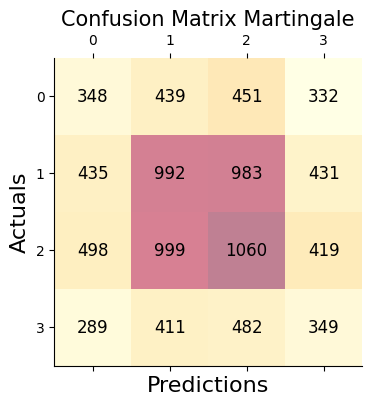

In [94]:
fig, px = plt.subplots(figsize=(4, 4))
px.matshow(confusion_mart, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(confusion_mart.shape[0]):
    for n in range(confusion_mart.shape[1]):
        px.text(x=m,y=n,s=confusion_mart[m, n], va='center', ha='center', size='large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix Martingale', fontsize=15)
plt.show()

<AxesSubplot:>

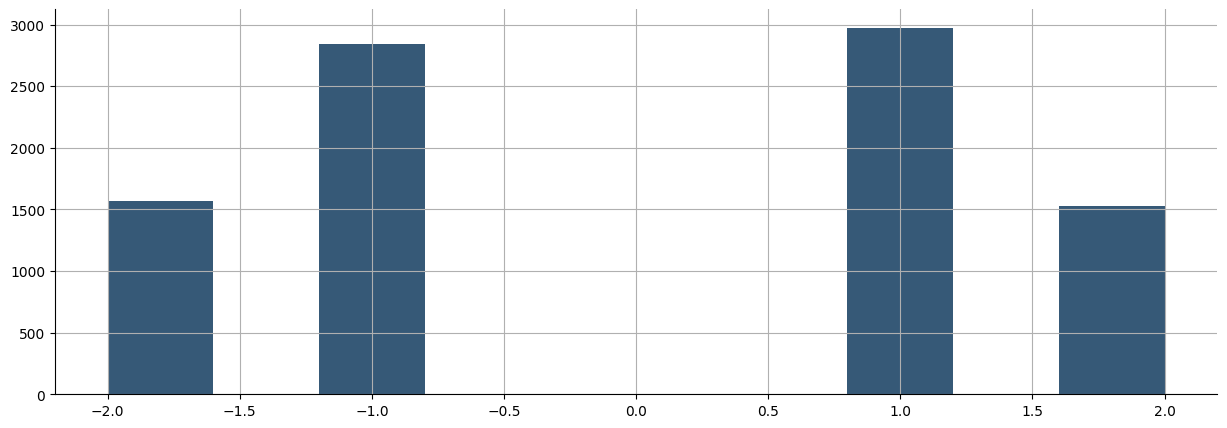

In [95]:
ohlc2['sign'].hist()

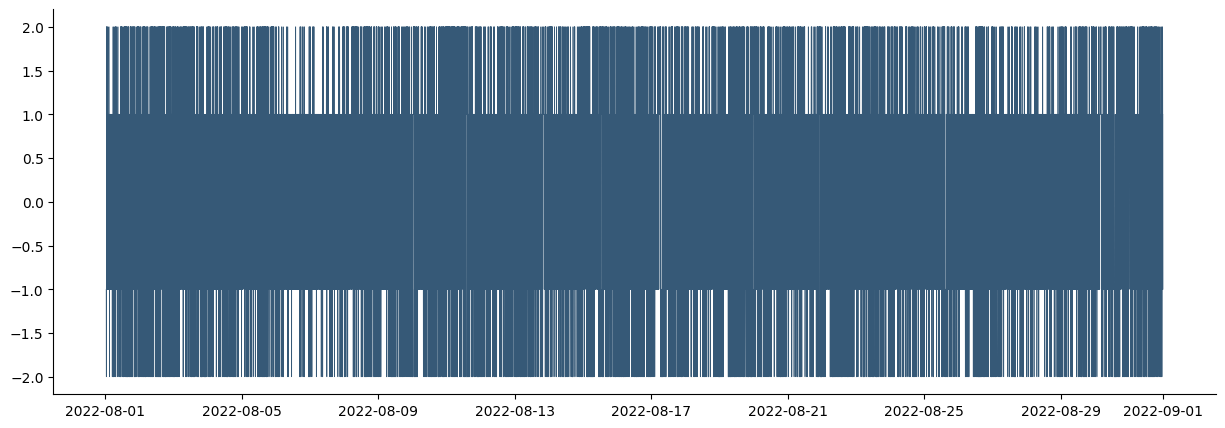

In [96]:
plt.plot(ohlc2['sign'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1c19d0103d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c19d011660>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c19d013dc0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c19d012980>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c19d013370>],
 'means': []}

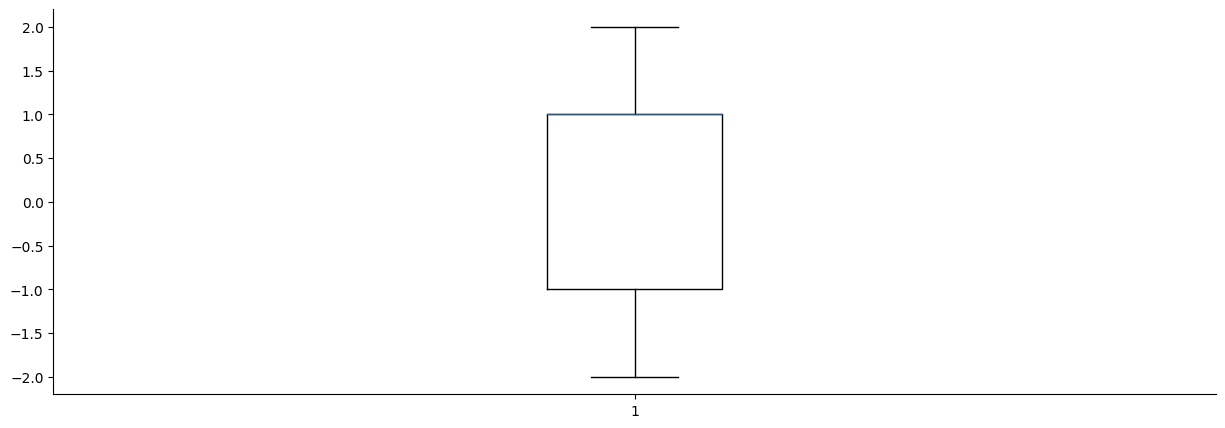

In [97]:
plt.boxplot(ohlc2['sign'], notch=None, vert=None, patch_artist=None, widths=None)

# <font color= #6B6B6B> 4.2. Feature Selection and feature transformation   </font>


Then we will apply different normalization and scaling methods to transform the data, then selecting the features to use on the following models, this because is a requirement for models like log regression, and also because we have different scales on the information.

                 open      high       low     close    volume  \
open         1.000000  0.999840  0.999800  0.999709 -0.104620   
high         0.999840  1.000000  0.999732  0.999852 -0.096310   
low          0.999800  0.999732  1.000000  0.999867 -0.115094   
close        0.999709  0.999852  0.999867  1.000000 -0.106095   
volume      -0.104620 -0.096310 -0.115094 -0.106095  1.000000   
...               ...       ...       ...       ...       ...   
lag_vol_10  -0.109226 -0.107419 -0.112464 -0.110155  0.349618   
sum_vol_10  -0.140250 -0.135278 -0.146232 -0.140838  0.701181   
mean_vol_10 -0.140250 -0.135278 -0.146232 -0.140838  0.701181   
sign         0.004449  0.003773  0.004236  0.003158 -0.015463   
martingale   0.022464  0.022463  0.023142  0.022184 -0.034070   

             quote_asset_volume    trades  buy_asset_volume  \
open                  -0.003477  0.017630         -0.106879   
high                   0.005002  0.025651         -0.097180   
low                   -0.01396

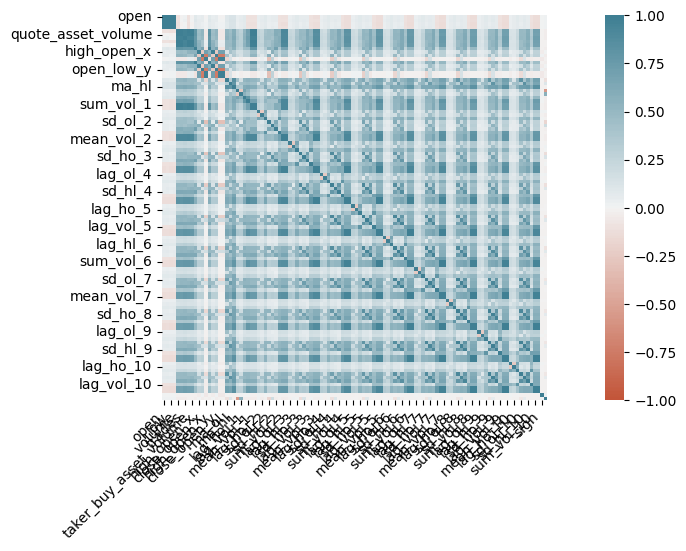

In [98]:
# Heat map
correlation = ohlc2.corr()
print(correlation)

heat = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
heat.set_xticklabels(
    heat.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

                 open      high       low     close    volume  \
open         1.000000  0.999533  0.999507  0.999157 -0.083916   
high         0.999533  1.000000  0.999324  0.999604 -0.073309   
low          0.999507  0.999324  1.000000  0.999601 -0.095375   
close        0.999157  0.999604  0.999601  1.000000 -0.084545   
volume      -0.083916 -0.073309 -0.095375 -0.084545  1.000000   
...               ...       ...       ...       ...       ...   
lag_vol_10  -0.084073 -0.080938 -0.088085 -0.084565  0.459644   
sum_vol_10  -0.100502 -0.093528 -0.107787 -0.100552  0.774359   
mean_vol_10 -0.100502 -0.093528 -0.107787 -0.100552  0.774359   
sign        -0.003769 -0.004743 -0.004023 -0.005720 -0.006459   
martingale   0.026048  0.026100  0.026591  0.025312 -0.013265   

             quote_asset_volume    trades  buy_asset_volume  \
open                   0.033693  0.065450         -0.083989   
high                   0.044383  0.075383         -0.071945   
low                    0.02214

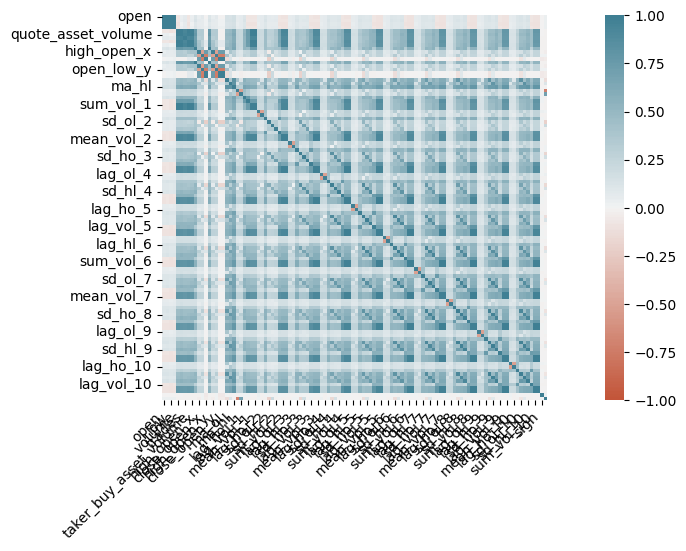

In [99]:
# Heat map spearman
correlation = ohlc2.corr(method= 'spearman')
print(correlation)

heat = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
heat.set_xticklabels(
    heat.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

                 open      high       low     close    volume  \
open         1.000000  0.984777  0.984128  0.977346 -0.056320   
high         0.984777  1.000000  0.981369  0.985469 -0.048774   
low          0.984128  0.981369  1.000000  0.985714 -0.064412   
close        0.977346  0.985469  0.985714  1.000000 -0.056755   
volume      -0.056320 -0.048774 -0.064412 -0.056755  1.000000   
...               ...       ...       ...       ...       ...   
lag_vol_10  -0.056413 -0.054192 -0.059257 -0.056792  0.318624   
sum_vol_10  -0.068178 -0.062958 -0.073633 -0.068222  0.581537   
mean_vol_10 -0.068178 -0.062958 -0.073633 -0.068222  0.581537   
sign        -0.002925 -0.003662 -0.003104 -0.004397 -0.004532   
martingale   0.019688  0.019720  0.020071  0.019106 -0.009346   

             quote_asset_volume    trades  buy_asset_volume  \
open                   0.021683  0.042843         -0.056754   
high                   0.029237  0.049985         -0.048215   
low                    0.01359

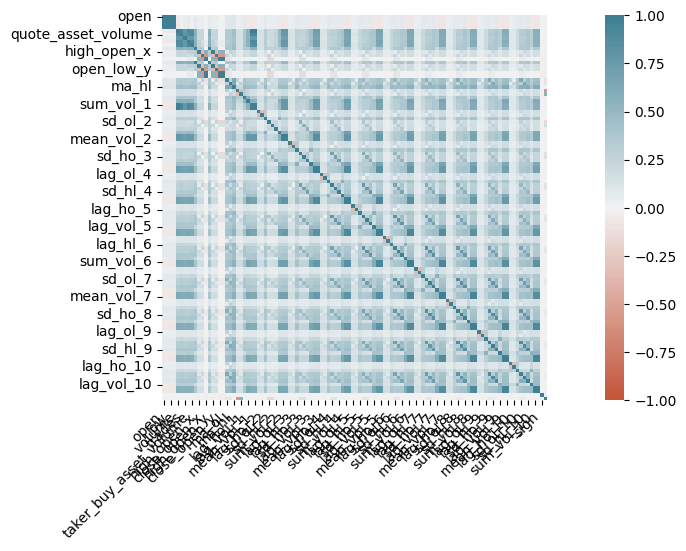

In [100]:
# Heat map kendall
correlation = ohlc2.corr(method = 'kendall')
print(correlation)

heat = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
heat.set_xticklabels(
    heat.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

In [101]:
X = ohlc2.iloc[:,:-2]
X.head()

open      high       low     close     volume  \
timestamp                                                                
2022-08-01 00:50:00  23373.51  23391.50  23366.40  23383.58  311.14844   
2022-08-01 00:55:00  23383.58  23389.12  23361.22  23374.96  280.08408   
2022-08-01 01:00:00  23376.65  23377.60  23335.92  23345.37  287.63410   
2022-08-01 01:05:00  23346.93  23375.45  23323.52  23363.46  346.86572   
2022-08-01 01:10:00  23363.46  23388.04  23352.80  23378.47  278.64902   

                     quote_asset_volume   trades  buy_asset_volume  \
timestamp                                                            
2022-08-01 00:50:00        7.274054e+06  12371.0         160.79904   
2022-08-01 00:55:00        6.547261e+06  11761.0         126.09530   
2022-08-01 01:00:00        6.717655e+06  12697.0         139.84261   
2022-08-01 01:05:00        8.099151e+06  12922.0         156.76484   
2022-08-01 01:10:00        6.512857e+06  11949.0         145.01419   

                     taker_buy_asset_volume  volatility_x  ...  mean_vol_9  \
timestamp                                                  ...               
2022-08-01 00:50:00            3.759219e+06         25.10  ...  411.653282   
2022-08-01 00:55:00            2.947750e+06         27.90  ...  397.563531   
2022-08-01 01:00:00            3.266103e+06         41.68  ...  354.730503   
2022-08-01 01:05:00            3.660857e+06         51.93  ...  364.361852   
2022-08-01 01:10:00            3.389582e+06         35.24  ...  336.139582   

                     lag_ol_10  lag_ho_10  lag_hl_10   sd_ol_10   sd_ho_10  \
timestamp                                                                    
2022-08-01 00:50:00      34.09      21.36      55.45   7.772602  15.288080   
2022-08-01 00:55:00      17.38      11.09      28.47   8.140152  16.291041   
2022-08-01 01:00:00       5.09      37.67      42.76  10.775461  19.182949   
2022-08-01 01:05:00      14.69      59.25      73.94  10.794865  16.216903   
2022-08-01 01:10:00      14.77      34.04      48.81  11.060213  16.033737   

                      sd_hl_10  lag_vol_10  sum_vol_10  mean_vol_10  
timestamp                                                            
2022-08-01 00:50:00  16.418417   651.57251  4178.93536   417.893536  
2022-08-01 00:55:00  16.496904   474.05582  3984.96362   398.496362  
2022-08-01 01:00:00  16.542508   406.89184  3865.70588   386.570588  
2022-08-01 01:05:00  14.049726   673.13135  3539.44025   353.944025  
2022-08-01 01:10:00  14.424575   260.18358  3557.90569   355.790569  

[5 rows x 108 columns]

In [102]:
y = ohlc2['sign'].copy()
y_true = y.copy()
y.head()

timestamp
2022-08-01 00:50:00   -1.0
2022-08-01 00:55:00   -2.0
2022-08-01 01:00:00    1.0
2022-08-01 01:05:00    1.0
2022-08-01 01:10:00    2.0
Name: sign, dtype: float64

In [103]:
from gplearn.genetic import SymbolicTransformer                               # variables simbolicas


In [146]:
def genetic_programed_features(p_data, p_target, p_params):
    """
    El uso de programacion genetica para generar variables independientes simbolicas
    Parameters
    ----------
    p_data: pd.DataFrame
        con datos completos para ajustar modelos
        
        p_data = m_folds['periodo_1']
    p_split: int
        split in val
        p_split = '0'
    p_params:
        parameters for symbolic_features process 
    Returns
    -------
    model_data: dict
        {'train_x': pd.DataFrame, 'train_y': pd.DataFrame, 'val_x': pd.DataFrame, 'val_y': pd.DataFrame}
    References
    ----------
    https://stackoverflow.com/questions/3819977/
    what-are-the-differences-between-genetic-algorithms-and-genetic-programming
    """
   
    # separacion de variable dependiente
    datos_y = y.copy().astype(int)

    # separacion de variables independientes
    datos_had = X.copy()
    # Lista de operaciones simbolicas
    sym_data = symbolic_features(p_x=datos_had, p_y=datos_y, p_params=symbolic_params)

    # Symbolic variables output
    datos_sym = sym_data['data'].copy()
    datos_sym.columns = ['sym_' + str(i) for i in range(0, len(sym_data['data'].iloc[0, :]))]
    datos_sym.index = datos_y.index
   
    return {'sym_data': sym_data, 'sym_features': datos_sym}


In [147]:
genetic_prog = genetic_programed_features(p_data=X, p_target=y, p_params=symbolic_params)

# Process description
sym_process = pd.DataFrame(genetic_prog['sym_data']['details'])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    25.47       0.00943426        3        0.0602406              N/A     14.77s
   1     2.88         0.012982        3        0.0610112              N/A     14.40s
   2     2.45        0.0171603        3        0.0658207              N/A      8.79s
   3     2.24        0.0316855        6        0.0536595              N/A      4.67s
   4     2.22        0.0405892        3        0.0658207              N/A      0.00s


In [148]:
sym_features = genetic_prog['sym_features']
sym_features

sym_0     sym_1     sym_2      sym_3        sym_4  sym_5  \
timestamp                                                                       
2022-08-01 00:50:00 -17.18  0.062625  0.002718  15.832920  235472.6506  10.07   
2022-08-01 00:55:00 -13.74 -0.068361 -0.002409   2.163378 -201492.1552  -8.62   
2022-08-01 01:00:00  -9.45 -0.223680 -0.009798 -18.290448 -730243.1736 -31.28   
2022-08-01 01:05:00 -39.94  0.105445  0.005041  28.777089  386197.9938  16.53   
2022-08-01 01:10:00 -25.67  0.103507  0.004962  24.025611  350910.8347  15.01   
...                    ...       ...       ...        ...          ...    ...   
2022-08-31 23:35:00  -9.44 -0.016518 -0.000753  12.565121  -93167.5198  -4.66   
2022-08-31 23:40:00 -39.37  0.027167  0.001862  21.482891  246866.2658  12.34   
2022-08-31 23:45:00 -33.53  0.053279  0.004302  46.753578  602666.3360  30.08   
2022-08-31 23:50:00 -17.92  0.018238  0.000670  11.561570   90981.5546   4.54   
2022-08-31 23:55:00 -14.99  0.042138  0.001529  15.983839  201101.7006  10.03   

                     sym_6  sym_7  sym_8  sym_9  sym_10  sym_11  sym_12  \
timestamp                                                                 
2022-08-01 00:50:00  10.07  10.07  10.07  10.07   10.07   10.07   10.07   
2022-08-01 00:55:00  -8.62  -8.62  -8.62  -8.62   -8.62   -8.62   -8.62   
2022-08-01 01:00:00 -31.28 -31.28 -31.28 -31.28  -31.28  -31.28  -31.28   
2022-08-01 01:05:00  16.53  16.53  16.53  16.53   16.53   16.53   16.53   
2022-08-01 01:10:00  15.01  15.01  15.01  15.01   15.01   15.01   15.01   
...                    ...    ...    ...    ...     ...     ...     ...   
2022-08-31 23:35:00  -4.66  -4.66  -4.66  -4.66   -4.66   -4.66   -4.66   
2022-08-31 23:40:00  12.34  12.34  12.34  12.34   12.34   12.34   12.34   
2022-08-31 23:45:00  30.08  30.08  30.08  30.08   30.08   30.08   30.08   
2022-08-31 23:50:00   4.54   4.54   4.54   4.54    4.54    4.54    4.54   
2022-08-31 23:55:00  10.03  10.03  10.03  10.03   10.03   10.03   10.03   

                     sym_13  sym_14  sym_15  sym_16  sym_17  sym_18  sym_19  
timestamp                                                                    
2022-08-01 00:50:00   10.07   10.07   10.07   10.07   10.07   10.07   10.07  
2022-08-01 00:55:00   -8.62   -8.62   -8.62   -8.62   -8.62   -8.62   -8.62  
2022-08-01 01:00:00  -31.28  -31.28  -31.28  -31.28  -31.28  -31.28  -31.28  
2022-08-01 01:05:00   16.53   16.53   16.53   16.53   16.53   16.53   16.53  
2022-08-01 01:10:00   15.01   15.01   15.01   15.01   15.01   15.01   15.01  
...                     ...     ...     ...     ...     ...     ...     ...  
2022-08-31 23:35:00   -4.66   -4.66   -4.66   -4.66   -4.66   -4.66   -4.66  
2022-08-31 23:40:00   12.34   12.34   12.34   12.34   12.34   12.34   12.34  
2022-08-31 23:45:00   30.08   30.08   30.08   30.08   30.08   30.08   30.08  
2022-08-31 23:50:00    4.54    4.54    4.54    4.54    4.54    4.54    4.54  
2022-08-31 23:55:00   10.03   10.03   10.03   10.03   10.03   10.03   10.03  

[8918 rows x 20 columns]

We now perform a chi squared test, to se the relevant features

To use the data in the log regression we require to fit the data trought transformations as the data has different scales which would give us a bad forecast.

* The first one is the Normalizer which transforms numeric columns to a standard scale. in this instance it is done by the maximum absolute scaling method which has the following formula:
$$ x_{scaled} =\frac{ x}{max(|x|)} $$

In [149]:
# Normalizer
transformer = Normalizer(norm= 'max').fit(X) 
transformed = transformer.transform(X)
X_normalized = pd.DataFrame(transformed,index = X.index, columns= X.columns)
X_normalized.head()

open      high       low     close    volume  \
timestamp                                                               
2022-08-01 00:50:00  0.003213  0.003216  0.003212  0.003215  0.000043   
2022-08-01 00:55:00  0.003572  0.003572  0.003568  0.003570  0.000043   
2022-08-01 01:00:00  0.003480  0.003480  0.003474  0.003475  0.000043   
2022-08-01 01:05:00  0.002883  0.002886  0.002880  0.002885  0.000043   
2022-08-01 01:10:00  0.003587  0.003591  0.003586  0.003590  0.000043   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2022-08-01 00:50:00                 1.0  0.001701          0.000022   
2022-08-01 00:55:00                 1.0  0.001796          0.000019   
2022-08-01 01:00:00                 1.0  0.001890          0.000021   
2022-08-01 01:05:00                 1.0  0.001595          0.000019   
2022-08-01 01:10:00                 1.0  0.001835          0.000022   

                     taker_buy_asset_volume  volatility_x  ...  mean_vol_9  \
timestamp                                                  ...               
2022-08-01 00:50:00                0.516798      0.000003  ...    0.000057   
2022-08-01 00:55:00                0.450226      0.000004  ...    0.000061   
2022-08-01 01:00:00                0.486197      0.000006  ...    0.000053   
2022-08-01 01:05:00                0.452005      0.000006  ...    0.000045   
2022-08-01 01:10:00                0.520445      0.000005  ...    0.000052   

                        lag_ol_10  lag_ho_10  lag_hl_10  sd_ol_10  sd_ho_10  \
timestamp                                                                     
2022-08-01 00:50:00  4.686520e-06   0.000003   0.000008  0.000001  0.000002   
2022-08-01 00:55:00  2.654545e-06   0.000002   0.000004  0.000001  0.000002   
2022-08-01 01:00:00  7.577049e-07   0.000006   0.000006  0.000002  0.000003   
2022-08-01 01:05:00  1.813770e-06   0.000007   0.000009  0.000001  0.000002   
2022-08-01 01:10:00  2.267822e-06   0.000005   0.000007  0.000002  0.000002   

                     sd_hl_10  lag_vol_10  sum_vol_10  mean_vol_10  
timestamp                                                           
2022-08-01 00:50:00  0.000002    0.000090    0.000574     0.000057  
2022-08-01 00:55:00  0.000003    0.000072    0.000609     0.000061  
2022-08-01 01:00:00  0.000002    0.000061    0.000575     0.000058  
2022-08-01 01:05:00  0.000002    0.000083    0.000437     0.000044  
2022-08-01 01:10:00  0.000002    0.000040    0.000546     0.000055  

[5 rows x 108 columns]

The second method chosen was Min Max Scaler, which transforms the features by scaling them to a given range in this case 0 to 1.

$$ X_{norm}= \frac{X-X_{min}} {X_{max}-X_{min}} $$

In [150]:
#  Min Max Scaler
scale = MinMaxScaler()
X_scale = scale.fit(X)
X_scale = scale.transform(X)
X_scale = pd.DataFrame(X_scale,index = X.index, columns= X.columns)
X_scale.head()

open      high       low     close    volume  \
timestamp                                                               
2022-08-01 00:50:00  0.683630  0.676080  0.690972  0.685212  0.035702   
2022-08-01 00:55:00  0.685433  0.675656  0.690042  0.683669  0.031533   
2022-08-01 01:00:00  0.684192  0.673606  0.685497  0.678372  0.032546   
2022-08-01 01:05:00  0.678870  0.673223  0.683269  0.681610  0.040495   
2022-08-01 01:10:00  0.681830  0.675464  0.688529  0.684297  0.031341   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2022-08-01 00:50:00            0.035875  0.072387          0.036419   
2022-08-01 00:55:00            0.031734  0.067959          0.027751   
2022-08-01 01:00:00            0.032705  0.074754          0.031185   
2022-08-01 01:05:00            0.040577  0.076388          0.035412   
2022-08-01 01:10:00            0.031538  0.069324          0.032477   

                     taker_buy_asset_volume  volatility_x  ...  mean_vol_9  \
timestamp                                                  ...               
2022-08-01 00:50:00                0.036222      0.018544  ...    0.083834   
2022-08-01 00:55:00                0.027606      0.020931  ...    0.079859   
2022-08-01 01:00:00                0.030986      0.032680  ...    0.067772   
2022-08-01 01:05:00                0.035178      0.041419  ...    0.070490   
2022-08-01 01:10:00                0.032297      0.027189  ...    0.062527   

                     lag_ol_10  lag_ho_10  lag_hl_10  sd_ol_10  sd_ho_10  \
timestamp                                                                  
2022-08-01 00:50:00   0.029409   0.029882   0.044420  0.014449  0.055802   
2022-08-01 00:55:00   0.014994   0.015515   0.021417  0.015483  0.060460   
2022-08-01 01:00:00   0.004391   0.052700   0.033601  0.022900  0.073891   
2022-08-01 01:05:00   0.012673   0.082890   0.060185  0.022954  0.060116   
2022-08-01 01:10:00   0.012742   0.047622   0.038759  0.023701  0.059265   

                     sd_hl_10  lag_vol_10  sum_vol_10  mean_vol_10  
timestamp                                                           
2022-08-01 00:50:00  0.038611    0.081383    0.086600     0.086600  
2022-08-01 00:55:00  0.038832    0.057562    0.080768     0.080768  
2022-08-01 01:00:00  0.038960    0.048550    0.077181     0.077181  
2022-08-01 01:05:00  0.031952    0.084276    0.067371     0.067371  
2022-08-01 01:10:00  0.033006    0.028863    0.067926     0.067926  

[5 rows x 108 columns]

The last one is the standardization method, which removes the mean and sacales to unit variance.

$$ Z=\frac{(X-u)}{S} $$
where:
* U = mean of the training samples 
* S= Standard deviation

In [151]:
# Standardize
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
X_standard = pd.DataFrame(scaled,index = X.index, columns= X.columns)
X_standard.head()

open      high       low     close    volume  \
timestamp                                                               
2022-08-01 00:50:00  0.610446  0.604780  0.623928  0.617428 -0.719282   
2022-08-01 00:55:00  0.617247  0.603174  0.620427  0.611607 -0.787685   
2022-08-01 01:00:00  0.612567  0.595402  0.603325  0.591627 -0.771060   
2022-08-01 01:05:00  0.592496  0.593951  0.594943  0.603842 -0.640634   
2022-08-01 01:10:00  0.603659  0.602445  0.614735  0.613978 -0.790845   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2022-08-01 00:50:00           -0.693737 -0.796040         -0.699266   
2022-08-01 00:55:00           -0.765911 -0.856864         -0.853524   
2022-08-01 01:00:00           -0.748990 -0.763534         -0.792417   
2022-08-01 01:05:00           -0.611800 -0.741098         -0.717198   
2022-08-01 01:10:00           -0.769328 -0.838118         -0.769429   

                     taker_buy_asset_volume  volatility_x  ...  mean_vol_9  \
timestamp                                                  ...               
2022-08-01 00:50:00               -0.671867     -0.774750  ...   -0.644962   
2022-08-01 00:55:00               -0.834446     -0.693276  ...   -0.685166   
2022-08-01 01:00:00               -0.770663     -0.292309  ...   -0.807387   
2022-08-01 01:05:00               -0.691574      0.005943  ...   -0.779905   
2022-08-01 01:10:00               -0.745924     -0.479698  ...   -0.860435   

                     lag_ol_10  lag_ho_10  lag_hl_10  sd_ol_10  sd_ho_10  \
timestamp                                                                  
2022-08-01 00:50:00   0.266211  -0.157769   0.107985 -0.793730 -0.389796   
2022-08-01 00:55:00  -0.297456  -0.545313  -0.677103 -0.772411 -0.316495   
2022-08-01 01:00:00  -0.712026   0.457699  -0.261280 -0.619550 -0.105141   
2022-08-01 01:05:00  -0.388196   1.272034   0.646023 -0.618424 -0.321913   
2022-08-01 01:10:00  -0.385498   0.320719  -0.085232 -0.603032 -0.335300   

                     sd_hl_10  lag_vol_10  sum_vol_10  mean_vol_10  
timestamp                                                           
2022-08-01 00:50:00 -0.271107    0.030985   -0.635930    -0.635930  
2022-08-01 00:55:00 -0.266860   -0.359875   -0.692057    -0.692057  
2022-08-01 01:00:00 -0.264392   -0.507758   -0.726565    -0.726565  
2022-08-01 01:05:00 -0.399283    0.078453   -0.820973    -0.820973  
2022-08-01 01:10:00 -0.378999   -0.830784   -0.815630    -0.815630  

[5 rows x 108 columns]

                 open      high       low     close    volume  \
open         1.000000  0.999999  0.999999  0.999998 -0.113924   
high         0.999999  1.000000  0.999999  0.999999 -0.113981   
low          0.999999  0.999999  1.000000  0.999999 -0.113853   
close        0.999998  0.999999  0.999999  1.000000 -0.113936   
volume      -0.113924 -0.113981 -0.113853 -0.113936  1.000000   
...               ...       ...       ...       ...       ...   
sd_ho_10     0.548480  0.548592  0.548369  0.548483 -0.073271   
sd_hl_10     0.481823  0.481903  0.481712  0.481799 -0.095671   
lag_vol_10   0.400409  0.400404  0.400428  0.400422  0.119208   
sum_vol_10   0.498005  0.497971  0.498047  0.498003  0.198315   
mean_vol_10  0.498005  0.497971  0.498047  0.498003  0.198315   

             quote_asset_volume    trades  buy_asset_volume  \
open                        NaN  0.778237         -0.055649   
high                        NaN  0.778207         -0.055222   
low                         Na

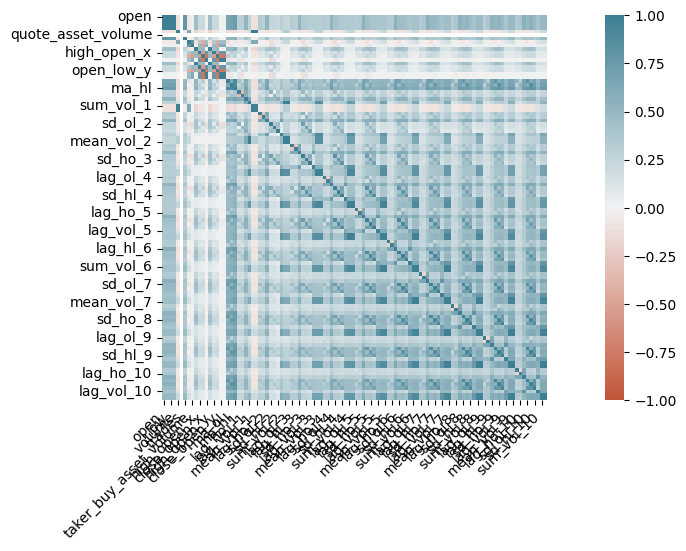

In [152]:
# Heat map
correlation = X_normalized.corr()
print(correlation)

heat = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
heat.set_xticklabels(
    heat.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

             open  high  low  close  volume  quote_asset_volume  trades  \
open          1.0  -0.2 -0.4   -1.0     NaN                 NaN     NaN   
high         -0.2   1.0  0.8    0.2     NaN                 NaN     NaN   
low          -0.4   0.8  1.0    0.4     NaN                 NaN     NaN   
close        -1.0   0.2  0.4    1.0     NaN                 NaN     NaN   
volume        NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
...           ...   ...  ...    ...     ...                 ...     ...   
sd_ho_10      NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
sd_hl_10      NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
lag_vol_10    NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
sum_vol_10    NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
mean_vol_10   NaN   NaN  NaN    NaN     NaN                 NaN     NaN   

             buy_asset_volume  taker_buy_asset_volume  volatility_x  ...  \
open                   

<AxesSubplot:>

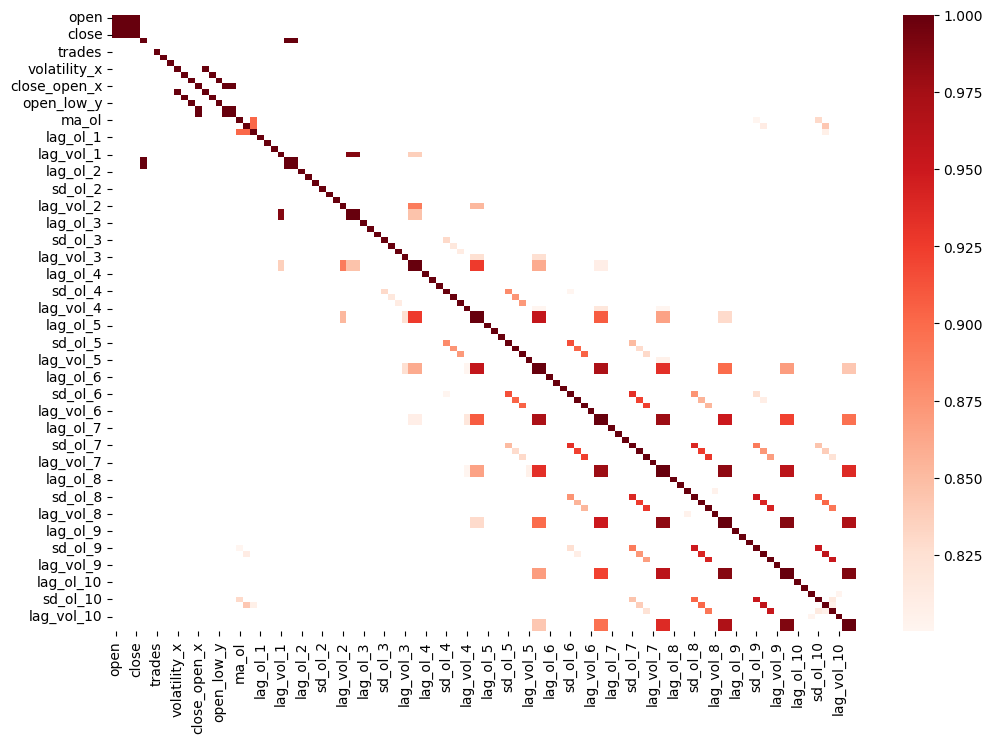

In [153]:
corr = correlation[correlation>=.80]
corr2 = corr.corr(method ='spearman')
print(corr2)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Reds")

             open  high  low  close  volume  quote_asset_volume  trades  \
open          1.0  -0.2 -0.4   -1.0     NaN                 NaN     NaN   
high         -0.2   1.0  0.8    0.2     NaN                 NaN     NaN   
low          -0.4   0.8  1.0    0.4     NaN                 NaN     NaN   
close        -1.0   0.2  0.4    1.0     NaN                 NaN     NaN   
volume        NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
...           ...   ...  ...    ...     ...                 ...     ...   
sd_ho_10      NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
sd_hl_10      NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
lag_vol_10    NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
sum_vol_10    NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
mean_vol_10   NaN   NaN  NaN    NaN     NaN                 NaN     NaN   

             buy_asset_volume  taker_buy_asset_volume  volatility_x  ...  \
open                   

<AxesSubplot:>

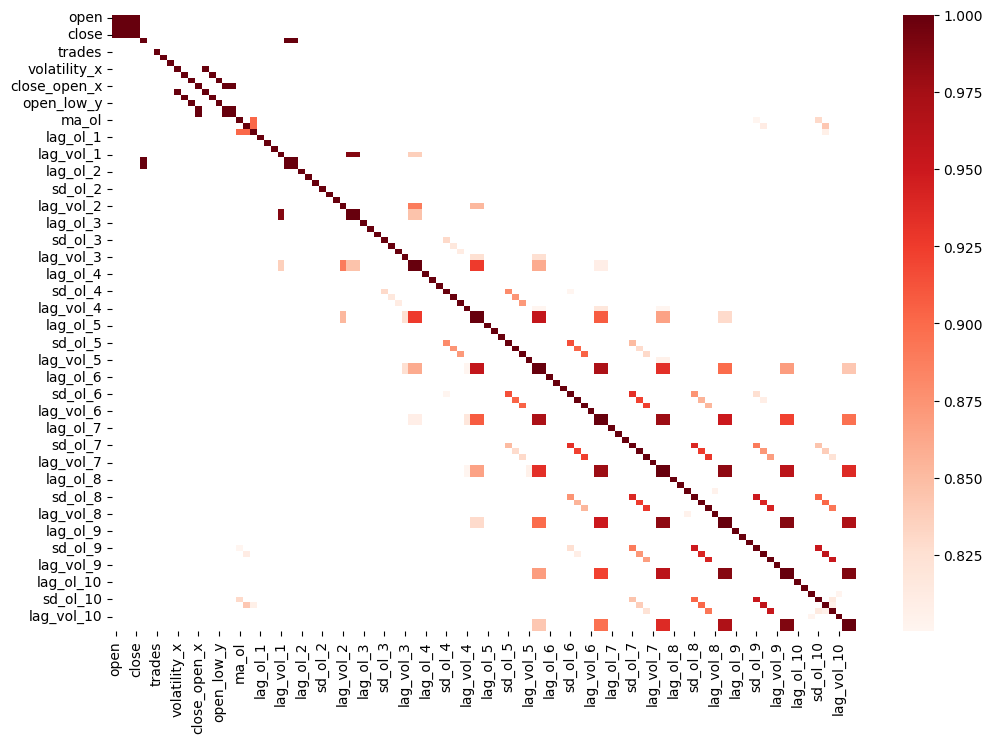

In [154]:
corr = correlation[correlation>=.80]
corr2 = corr.corr(method ='spearman')
print(corr2)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Reds")

In [155]:
cor_matrix = X_normalized.corr().abs()
print(cor_matrix)

                 open      high       low     close    volume  \
open         1.000000  0.999999  0.999999  0.999998  0.113924   
high         0.999999  1.000000  0.999999  0.999999  0.113981   
low          0.999999  0.999999  1.000000  0.999999  0.113853   
close        0.999998  0.999999  0.999999  1.000000  0.113936   
volume       0.113924  0.113981  0.113853  0.113936  1.000000   
...               ...       ...       ...       ...       ...   
sd_ho_10     0.548480  0.548592  0.548369  0.548483  0.073271   
sd_hl_10     0.481823  0.481903  0.481712  0.481799  0.095671   
lag_vol_10   0.400409  0.400404  0.400428  0.400422  0.119208   
sum_vol_10   0.498005  0.497971  0.498047  0.498003  0.198315   
mean_vol_10  0.498005  0.497971  0.498047  0.498003  0.198315   

             quote_asset_volume    trades  buy_asset_volume  \
open                        NaN  0.778237          0.055649   
high                        NaN  0.778207          0.055222   
low                         Na

In [156]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
print(upper_tri)

             open      high       low     close    volume  quote_asset_volume  \
open          NaN  0.999999  0.999999  0.999998  0.113924                 NaN   
high          NaN       NaN  0.999999  0.999999  0.113981                 NaN   
low           NaN       NaN       NaN  0.999999  0.113853                 NaN   
close         NaN       NaN       NaN       NaN  0.113936                 NaN   
volume        NaN       NaN       NaN       NaN       NaN                 NaN   
...           ...       ...       ...       ...       ...                 ...   
sd_ho_10      NaN       NaN       NaN       NaN       NaN                 NaN   
sd_hl_10      NaN       NaN       NaN       NaN       NaN                 NaN   
lag_vol_10    NaN       NaN       NaN       NaN       NaN                 NaN   
sum_vol_10    NaN       NaN       NaN       NaN       NaN                 NaN   
mean_vol_10   NaN       NaN       NaN       NaN       NaN                 NaN   

               trades  buy_

C:\Users\Emilio\AppData\Local\Temp\ipykernel_2092\3477284062.py:1: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [157]:
#.5 according to JF, but not many features after that.
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= .85)]
print(); print(to_drop)


['high', 'low', 'close', 'volatility_y', 'high_open_y', 'open_low_y', 'close_open_y', 'co', 'ma_hl', 'sum_vol_1', 'mean_vol_1', 'sum_vol_2', 'mean_vol_2', 'sum_vol_3', 'mean_vol_3', 'sum_vol_4', 'mean_vol_4', 'sd_ol_5', 'sd_ho_5', 'sd_hl_5', 'sum_vol_5', 'mean_vol_5', 'sd_ol_6', 'sd_ho_6', 'sd_hl_6', 'sum_vol_6', 'mean_vol_6', 'sd_ol_7', 'sd_ho_7', 'sd_hl_7', 'sum_vol_7', 'mean_vol_7', 'sd_ol_8', 'sd_ho_8', 'sd_hl_8', 'sum_vol_8', 'mean_vol_8', 'sd_ol_9', 'sd_ho_9', 'sd_hl_9', 'sum_vol_9', 'mean_vol_9', 'sd_ol_10', 'sd_ho_10', 'sd_hl_10', 'sum_vol_10', 'mean_vol_10']


In [158]:
#x = X_standard.copy()
x = X_scale.copy()
#x = X_normalized.copy()
#x = X.copy()

In [159]:
x = x.drop(x[to_drop],axis=1)
print(); print(x.head())
x.head()


                         open    volume  quote_asset_volume    trades  \
timestamp                                                               
2022-08-01 00:50:00  0.683630  0.035702            0.035875  0.072387   
2022-08-01 00:55:00  0.685433  0.031533            0.031734  0.067959   
2022-08-01 01:00:00  0.684192  0.032546            0.032705  0.074754   
2022-08-01 01:05:00  0.678870  0.040495            0.040577  0.076388   
2022-08-01 01:10:00  0.681830  0.031341            0.031538  0.069324   

                     buy_asset_volume  taker_buy_asset_volume  volatility_x  \
timestamp                                                                     
2022-08-01 00:50:00          0.036419                0.036222      0.018544   
2022-08-01 00:55:00          0.027751                0.027606      0.020931   
2022-08-01 01:00:00          0.031185                0.030986      0.032680   
2022-08-01 01:05:00          0.035412                0.035178      0.041419   
2022-08-01 01

open    volume  quote_asset_volume    trades  \
timestamp                                                               
2022-08-01 00:50:00  0.683630  0.035702            0.035875  0.072387   
2022-08-01 00:55:00  0.685433  0.031533            0.031734  0.067959   
2022-08-01 01:00:00  0.684192  0.032546            0.032705  0.074754   
2022-08-01 01:05:00  0.678870  0.040495            0.040577  0.076388   
2022-08-01 01:10:00  0.681830  0.031341            0.031538  0.069324   

                     buy_asset_volume  taker_buy_asset_volume  volatility_x  \
timestamp                                                                     
2022-08-01 00:50:00          0.036419                0.036222      0.018544   
2022-08-01 00:55:00          0.027751                0.027606      0.020931   
2022-08-01 01:00:00          0.031185                0.030986      0.032680   
2022-08-01 01:05:00          0.035412                0.035178      0.041419   
2022-08-01 01:10:00          0.032477                0.032297      0.027189   

                     high_open_x  open_low_x  close_open_x  ...  lag_hl_8  \
timestamp                                                   ...             
2022-08-01 00:50:00     0.025168    0.006134      0.609349  ...  0.033601   
2022-08-01 00:55:00     0.007750    0.019290      0.594046  ...  0.060185   
2022-08-01 01:00:00     0.001329    0.035138      0.575491  ...  0.038759   
2022-08-01 01:05:00     0.039899    0.020196      0.614639  ...  0.048334   
2022-08-01 01:10:00     0.034387    0.009196      0.613394  ...  0.056953   

                     lag_vol_8  lag_ol_9  lag_ho_9  lag_hl_9  lag_vol_9  \
timestamp                                                                 
2022-08-01 00:50:00   0.048550  0.014994  0.015515  0.021417   0.057562   
2022-08-01 00:55:00   0.084276  0.004391  0.052700  0.033601   0.048550   
2022-08-01 01:00:00   0.028863  0.012673  0.082890  0.060185   0.084276   
2022-08-01 01:05:00   0.065425  0.012742  0.047622  0.038759   0.028863   
2022-08-01 01:10:00   0.048155  0.004469  0.076749  0.048334   0.065425   

                     lag_ol_10  lag_ho_10  lag_hl_10  lag_vol_10  
timestamp                                                         
2022-08-01 00:50:00   0.029409   0.029882   0.044420    0.081383  
2022-08-01 00:55:00   0.014994   0.015515   0.021417    0.057562  
2022-08-01 01:00:00   0.004391   0.052700   0.033601    0.048550  
2022-08-01 01:05:00   0.012673   0.082890   0.060185    0.084276  
2022-08-01 01:10:00   0.012742   0.047622   0.038759    0.028863  

[5 rows x 61 columns]

In [160]:
x

open    volume  quote_asset_volume    trades  \
timestamp                                                               
2022-08-01 00:50:00  0.683630  0.035702            0.035875  0.072387   
2022-08-01 00:55:00  0.685433  0.031533            0.031734  0.067959   
2022-08-01 01:00:00  0.684192  0.032546            0.032705  0.074754   
2022-08-01 01:05:00  0.678870  0.040495            0.040577  0.076388   
2022-08-01 01:10:00  0.681830  0.031341            0.031538  0.069324   
...                       ...       ...                 ...       ...   
2022-08-31 23:35:00  0.079158  0.074156            0.062526  0.085201   
2022-08-31 23:40:00  0.078324  0.104765            0.088474  0.116730   
2022-08-31 23:45:00  0.080534  0.120110            0.101753  0.147120   
2022-08-31 23:50:00  0.085920  0.062607            0.052852  0.066275   
2022-08-31 23:55:00  0.086733  0.055843            0.047115  0.054260   

                     buy_asset_volume  taker_buy_asset_volume  volatility_x  \
timestamp                                                                     
2022-08-01 00:50:00          0.036419                0.036222      0.018544   
2022-08-01 00:55:00          0.027751                0.027606      0.020931   
2022-08-01 01:00:00          0.031185                0.030986      0.032680   
2022-08-01 01:05:00          0.035412                0.035178      0.041419   
2022-08-01 01:10:00          0.032477                0.032297      0.027189   
...                               ...                     ...           ...   
2022-08-31 23:35:00          0.066722                0.056202      0.018638   
2022-08-31 23:40:00          0.109713                0.092707      0.039253   
2022-08-31 23:45:00          0.137276                0.116402      0.046663   
2022-08-31 23:50:00          0.058435                0.049278      0.025962   
2022-08-31 23:55:00          0.055710                0.046975      0.016540   

                     high_open_x  open_low_x  close_open_x  ...  lag_hl_8  \
timestamp                                                   ...             
2022-08-01 00:50:00     0.025168    0.006134      0.609349  ...  0.033601   
2022-08-01 00:55:00     0.007750    0.019290      0.594046  ...  0.060185   
2022-08-01 01:00:00     0.001329    0.035138      0.575491  ...  0.038759   
2022-08-01 01:05:00     0.039899    0.020196      0.614639  ...  0.048334   
2022-08-01 01:10:00     0.034387    0.009196      0.613394  ...  0.056953   
...                          ...         ...           ...  ...       ...   
2022-08-31 23:35:00     0.015543    0.012164      0.597288  ...  0.021375   
2022-08-31 23:40:00     0.031281    0.023319      0.611208  ...  0.045034   
2022-08-31 23:45:00     0.076427    0.002976      0.625734  ...  0.055444   
2022-08-31 23:50:00     0.028567    0.011543      0.604821  ...  0.035357   
2022-08-31 23:55:00     0.024888    0.004279      0.609317  ...  0.041266   

                     lag_vol_8  lag_ol_9  lag_ho_9  lag_hl_9  lag_vol_9  \
timestamp                                                                 
2022-08-01 00:50:00   0.048550  0.014994  0.015515  0.021417   0.057562   
2022-08-01 00:55:00   0.084276  0.004391  0.052700  0.033601   0.048550   
2022-08-01 01:00:00   0.028863  0.012673  0.082890  0.060185   0.084276   
2022-08-01 01:05:00   0.065425  0.012742  0.047622  0.038759   0.028863   
2022-08-01 01:10:00   0.048155  0.004469  0.076749  0.048334   0.065425   
...                        ...       ...       ...       ...        ...   
2022-08-31 23:35:00   0.046321  0.007704  0.027560  0.021554   0.064794   
2022-08-31 23:40:00   0.071272  0.022568  0.003162  0.021375   0.046321   
2022-08-31 23:45:00   0.091805  0.046275  0.003539  0.045034   0.071272   
2022-08-31 23:50:00   0.084758  0.052590  0.010381  0.055444   0.091805   
2022-08-31 23:55:00   0.102516  0.016460  0.036010  0.035357   0.084758   

                     lag_ol_10  lag_ho_10  lag_hl_10  lag_vol_10  
ti

The logistic Regression was chosen because of the type of target variable which is  categorical feature. 
* The cost function in this case is the following one:
$$ \underset{w,c}{min}\frac{1-p}{2}{w}^{T}w+\rho||w||_1+C\sum_{i=1}^{n}log(exp(-y_i(\mathrm{X}_{i}^{T}w+c))+1) $$

This cost function is the one used for Elastic Net regularization, which is a combination of the L1 and L2 penalizations.

Next we split the dataset, as this is a timeseries we require to split it without changing the timeline or it would influence the forecasting.

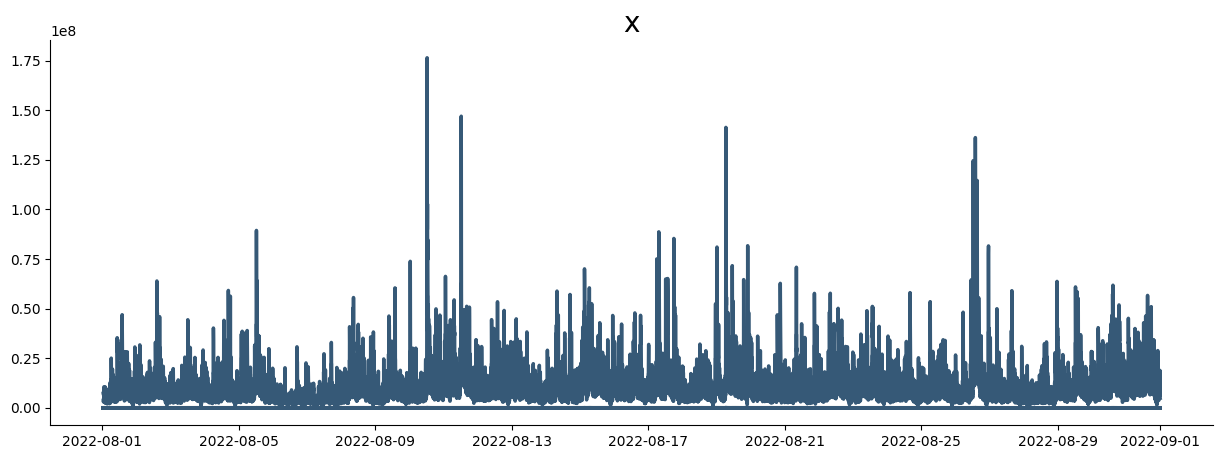

In [161]:
rcParams['figure.figsize'] = 15, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5
plt.title('x',size=20)
plt.plot(X)

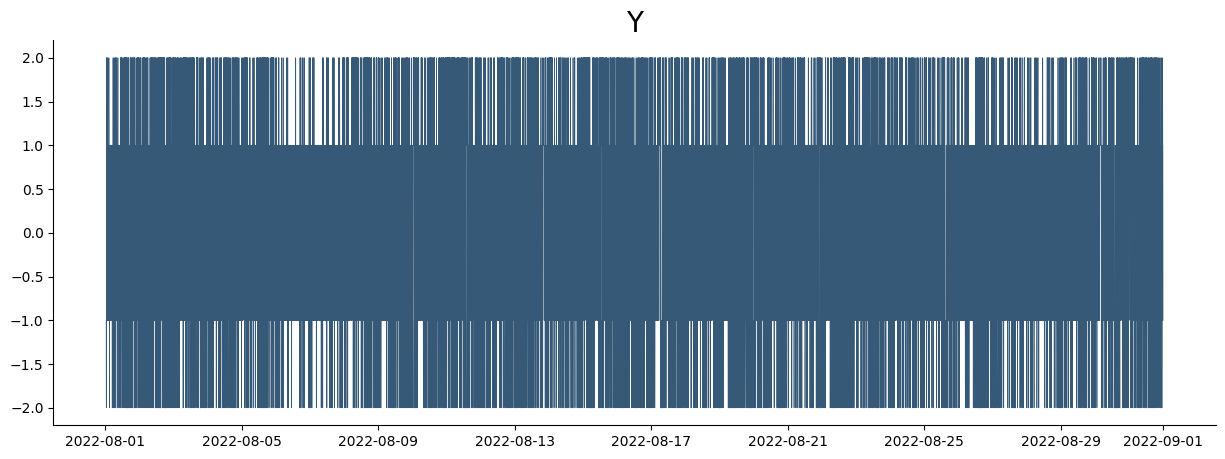

In [162]:
rcParams['figure.figsize'] = 15, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = .5
plt.title('Y',size=20)
plt.plot(y)

In [163]:
test_size = int(len(x)*.20)

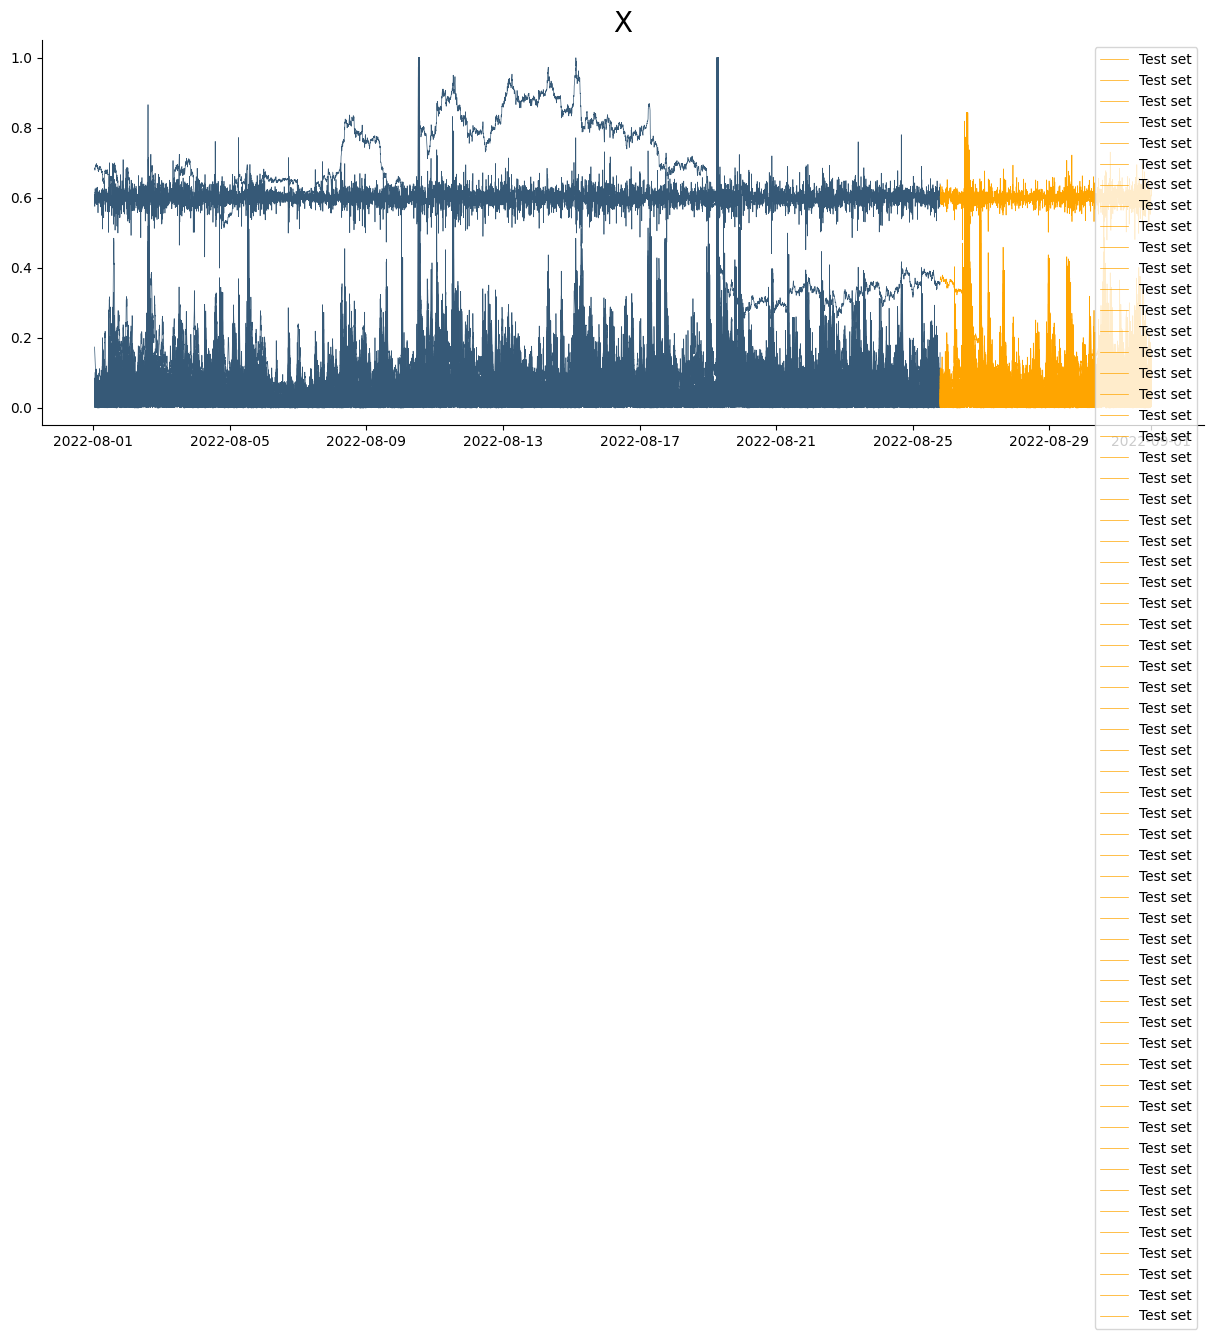

In [164]:
X_train = x[:-test_size].copy()
X_test = x[-test_size:].copy()
X_train2 =  x[:-test_size].copy()
X_test2 = x[-test_size:].copy()
X_train3 =  x[:-test_size].copy()
X_test3 = x[-test_size:].copy()

plt.title('X', size=20)
plt.plot(X_train) #,label='Training set')
plt.plot(X_test, label='Test set', color='orange')
plt.legend(loc = 'upper right');

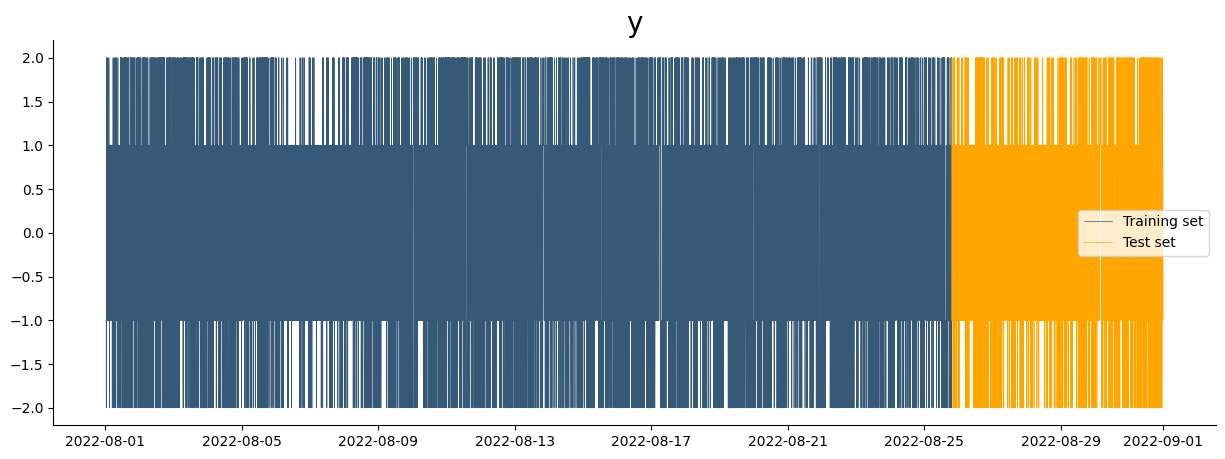

In [165]:
y_train = y[:-test_size].copy()
y_test = y[-test_size:].copy()
y_train2 = y[:-test_size].copy()
y_test2 = y[-test_size:].copy()



plt.title('y', size=20)
plt.plot(y_train, label='Training set')
plt.plot(y_test, label='Test set', color='orange')
plt.legend();

Now we apply the logistic regression, with the following parameters:
* C': 1,
* class_weight': None,
* dual': False,
* fit_intercept': True,
* intercept_scaling': 1,
* l1_ratio': 0.56,
* max_iter': 4000,
* multi_class': 'auto',
* penalty': 'elasticnet',
* random_state': False,
* solver': 'saga',
* tol': 0.0001,
* verbose': 0,
* warm_start': False}

In [166]:
# model fit
logistic_model = LogisticRegression(random_state=False, penalty='elasticnet',
                                    solver='saga', l1_ratio=.56, max_iter=1000000, C=1,
                                    class_weight = None,)
logistic_model.fit(X_train, y_train)

# logistic_model.predict_proba((X[:2, :])
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
logistic_model.score(x, y)
confusion_mat = confusion_matrix(y_test, y_pred)
print(accuracy)

36.791923724060574


In [167]:
logistic_model.get_params(deep=True)

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': 0.56,
 'max_iter': 1000000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'elasticnet',
 'random_state': False,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [168]:
# si fueron 0 se quitaron por efecto de la regularizacion L1 y son:
# si 
coef = logistic_model.coef_
print(logistic_model.intercept_)
coef

[-1.71356866 -0.09490029  1.80084944  0.00761951]


array([[ 1.20532370e-01,  0.00000000e+00,  3.75831334e-02,
         1.86705828e+00,  2.14044018e-01,  3.12704112e-01,
         8.99254155e-01,  5.01800516e-02,  1.12527767e-01,
         1.09233857e+00,  1.22239904e+00,  1.14619490e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.07465259e-01,
         0.00000000e+00,  0.00000000e+00,  5.07609210e-02,
         2.62965795e-01, -5.24015342e-01,  0.00000000e+00,
        -1.76939161e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -4.94392537e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.90618479e-01,
        -6.26154183e-02,  2.91234424e-01,  0.00000000e+00,
         3.75516869e-01,  0.00000000e+00,  0.00000000e+00,
         5.18283884e-01,  2.32906499e-01, -7.05756864e-02,
         0.00000000e+00,  1.61622858e-01,  0.00000000e+00,
         0.00000000e+00,  2.54237513e-01,  3.94765726e-0

In [169]:
predict_ = logistic_model.predict_proba(X_train)
predict_
# ver como funciona con cada clase, resultados no son fuertes, 
# 1) analisis de los coeficientes por efectos de la regularizacion ( estos se quitaron , estos se redujeron)
# 2) analisis probabilistico para cada clase.

array([[0.147837  , 0.35306476, 0.34673772, 0.15236051],
       [0.15067544, 0.32652663, 0.37812886, 0.14466908],
       [0.14497209, 0.34050865, 0.36659446, 0.14792479],
       ...,
       [0.12120585, 0.40291148, 0.35364375, 0.12223892],
       [0.11563116, 0.37501984, 0.37823615, 0.13111286],
       [0.16169902, 0.37391623, 0.31581876, 0.14856599]])

(1.0, 30000.0, -3.0, 3.0)

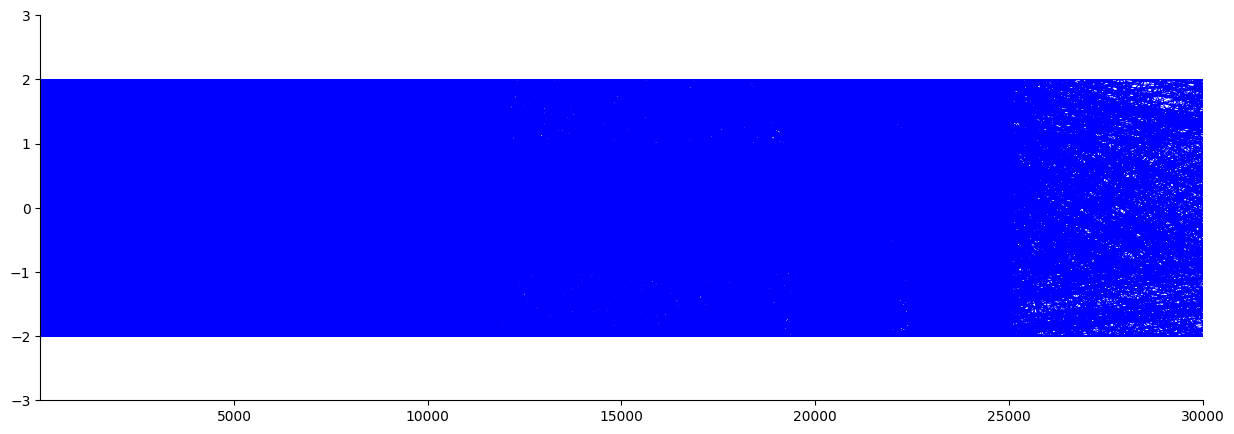

In [170]:
plt.plot(X_test,y_pred,'r')
plt.plot(X,y_true,'b')
plt.axis([1,30000,-3,3])

In [171]:
# logistic_model.predict_proba((X[:2, :])
y_pred = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred) * 100
logistic_model.score(x, y)
confusion_mat = confusion_matrix(y_test, y_pred)

recall_logistic = recall_score(y_test, y_pred,average = 'weighted') * 100
precision_logistic = precision_score(y_test, y_pred,average = 'weighted',zero_division = 0) * 100
f1_logistic = f1_score(y_test, y_pred,average = 'weighted') * 100
balanced_logistic = balanced_accuracy_score(y_test,y_pred) * 100

print('Accuracy:',accuracy_logistic,'%')
print('Recall:',recall_logistic,'%')
print('Precision:',precision_logistic,'%')
print('F1:',f1_logistic,'%')
print('Balanced Accuracy:',balanced_logistic,'%')
print("Confusion Matrix:")


print(confusion_mat)


Accuracy: 36.791923724060574 %
Recall: 36.791923724060574 %
Precision: 36.23150589994072 %
F1: 32.01022714108625 %
Balanced Accuracy: 29.66980891048223 %
Confusion Matrix:
[[ 24 161  54  45]
 [ 14 455 119  30]
 [ 11 444 141  28]
 [ 16 158  47  36]]


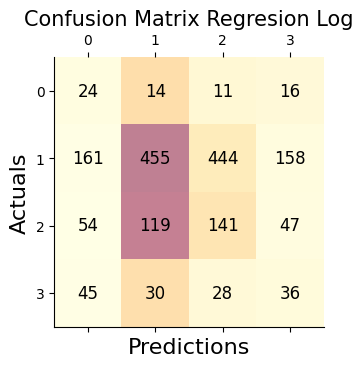

In [172]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, px = plt.subplots(figsize=(3.5, 3.5))
px.matshow(confusion_mat, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(confusion_mat.shape[0]):
    for n in range(confusion_mat.shape[1]):
        px.text(x=m,y=n,s=confusion_mat[m, n], va='center', ha='center', size='large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix Regresion Log', fontsize=15)
plt.show()

# 4.3 Naive Bayes

In [173]:
X_train.shape, X_test.shape

((7135, 61), (1783, 61))

In [174]:
# instantiate the model
gnb = GaussianNB()
#gnb = CategoricalNB()
pgmpy


# fit the model
gnb.fit(X_train2, y_train2)

GaussianNB()

In [175]:
y_pred2 = gnb.predict(X_test2)

In [176]:
accuracy_naive = (accuracy_score(y_test2, y_pred2))*100

recall_naive = recall_score(y_test2, y_pred2,average = 'weighted') * 100
precision_naive = precision_score(y_test2, y_pred2,average = 'weighted',zero_division = 0) * 100
f1_naive = f1_score(y_test2, y_pred2,average = 'weighted') * 100
balanced_naive = balanced_accuracy_score(y_test2, y_pred2) * 100
print('Accuracy:',accuracy_naive,'%')
print('Recall:',recall_naive,'%')
print('Precision:',precision_naive,'%')
print('F1:',f1_naive,'%')
print('Balanced Accuracy:',balanced_naive,'%')

Accuracy: 36.17498597868761 %
Recall: 36.17498597868761 %
Precision: 35.6585520049215 %
F1: 34.70379260183504 %
Balanced Accuracy: 31.65922897539406 %


In [177]:
y_pred_train = gnb.predict(X_train2)

In [178]:
conf_mat = confusion_matrix(y_test2, y_pred2)

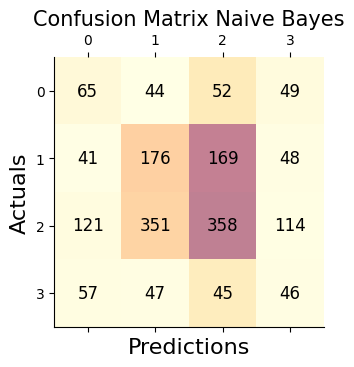

In [179]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, px = plt.subplots(figsize=(3.5, 3.5))
px.matshow(conf_mat, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(conf_mat.shape[0]):
    for n in range(conf_mat.shape[1]):
        px.text(x=m,y=n,s=conf_mat[m, n], va='center', ha='center', size='large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix Naive Bayes', fontsize=15)
plt.show()

## Random Forest

In [180]:
from sklearn.ensemble import RandomForestClassifier

X_train3 =  x[:-test_size].copy()
X_test3 = x[-test_size:].copy()
y_train3 = y[:-test_size].copy()
y_test3 = y[-test_size:].copy()

In [181]:
# Create a Random forest Classifier
clf = RandomForestClassifier(n_estimators = 1000,max_depth= None,
                             max_features= None,min_samples_split=2,
                            oob_score=True)
 
# Train the model using the training sets
clf.fit(X_train3, y_train3)

RandomForestClassifier(max_features=None, n_estimators=1000, oob_score=True)

In [182]:
# performing predictions on the test dataset
y_pred = clf.predict(X_test3)
accuracy_forest = accuracy_score(y_test3, y_pred) * 100
clf.score(x, y)
confusion_mat = confusion_matrix(y_test3, y_pred)

recall_forest = recall_score(y_test3, y_pred,average = 'weighted') * 100
precision_forest = precision_score(y_test3, y_pred,average = 'weighted',zero_division = 0) * 100
f1_forest = f1_score(y_test3, y_pred,average = 'weighted') * 100
balanced_forest = balanced_accuracy_score(y_test3,y_pred) * 100

print('Accuracy:',accuracy_forest,'%')
print('Recall:',recall_forest,'%')
print('Precision:',precision_forest,'%')
print('F1:',f1_forest,'%')
print('Balanced Accuracy:',balanced_forest,'%')
print("Confusion Matrix:")


print(confusion_mat)


Accuracy: 37.07234997195737 %
Recall: 37.07234997195737 %
Precision: 36.091979133129634 %
F1: 35.75252597135256 %
Balanced Accuracy: 31.588190842690416 %
Confusion Matrix:
[[ 46  83  98  57]
 [ 33 247 298  40]
 [ 30 233 319  42]
 [ 29  81  98  49]]


# 4.5 Multilayer Perceptron

In [183]:
#import tensorflow as tf
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense
import numpy as np

In [184]:
X_train4 = X_train.copy()
y_train4 = y_train.copy()
X_test4 = X_test.copy()
y_test4 = y_test.copy()
Y_train_dum = pd.get_dummies(y_train4,prefix='y')
Y_test_dum = pd.get_dummies(y_test4,prefix='y')

In [185]:
n_inputs = len(list(X_train4.columns))
n_inputs

61

In [186]:
# Neural network structure
model = Sequential()
model.add(Dense(10, activation='sigmoid', input_shape=(n_inputs,)))
#model.add(Dense(10, activation='softplus'))
model.add(Dense(4, activation='softmax'))
# Optimizer configuration
#model.compile(loss='binary_crossentropy',
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

Epoch 1/100
7135/7135 [==============================] - 8s 1ms/step - loss: 1.3449 - accuracy: 0.3264
Epoch 2/100
7135/7135 [==============================] - 7s 1ms/step - loss: 1.3220 - accuracy: 0.3379
Epoch 3/100
7135/7135 [==============================] - 7s 1ms/step - loss: 1.3130 - accuracy: 0.3382
Epoch 4/100
7135/7135 [==============================] - 7s 1ms/step - loss: 1.3108 - accuracy: 0.3381
Epoch 5/100
7135/7135 [==============================] - 8s 1ms/step - loss: 1.3093 - accuracy: 0.3427
Epoch 6/100
7135/7135 [==============================] - 8s 1ms/step - loss: 1.3092 - accuracy: 0.3406
Epoch 7/100
7135/7135 [==============================] - 7s 1ms/step - loss: 1.3085 - accuracy: 0.3452
Epoch 8/100
7135/7135 [==============================] - 8s 1ms/step - loss: 1.3083 - accuracy: 0.3352
Epoch 9/100
7135/7135 [==============================] - 7s 1ms/step - loss: 1.3073 - accuracy: 0.3397
Epoch 10/100
7135/7135 [==============================] - 7s 1ms/step - l

7135/7135 [==============================] - 8s 1ms/step - loss: 1.2965 - accuracy: 0.3559
Epoch 80/100
7135/7135 [==============================] - 8s 1ms/step - loss: 1.2953 - accuracy: 0.3582
Epoch 81/100
7135/7135 [==============================] - 8s 1ms/step - loss: 1.2957 - accuracy: 0.3596
Epoch 82/100
7135/7135 [==============================] - 8s 1ms/step - loss: 1.2960 - accuracy: 0.3605
Epoch 83/100
7135/7135 [==============================] - 8s 1ms/step - loss: 1.2959 - accuracy: 0.3610
Epoch 84/100
7135/7135 [==============================] - 8s 1ms/step - loss: 1.2958 - accuracy: 0.3643
Epoch 85/100
7135/7135 [==============================] - 8s 1ms/step - loss: 1.2952 - accuracy: 0.3640
Epoch 86/100
7135/7135 [==============================] - 8s 1ms/step - loss: 1.2952 - accuracy: 0.3601
Epoch 87/100
7135/7135 [==============================] - 8s 1ms/step - loss: 1.2946 - accuracy: 0.3523
Epoch 88/100
7135/7135 [==============================] - 8s 1ms/step - loss:

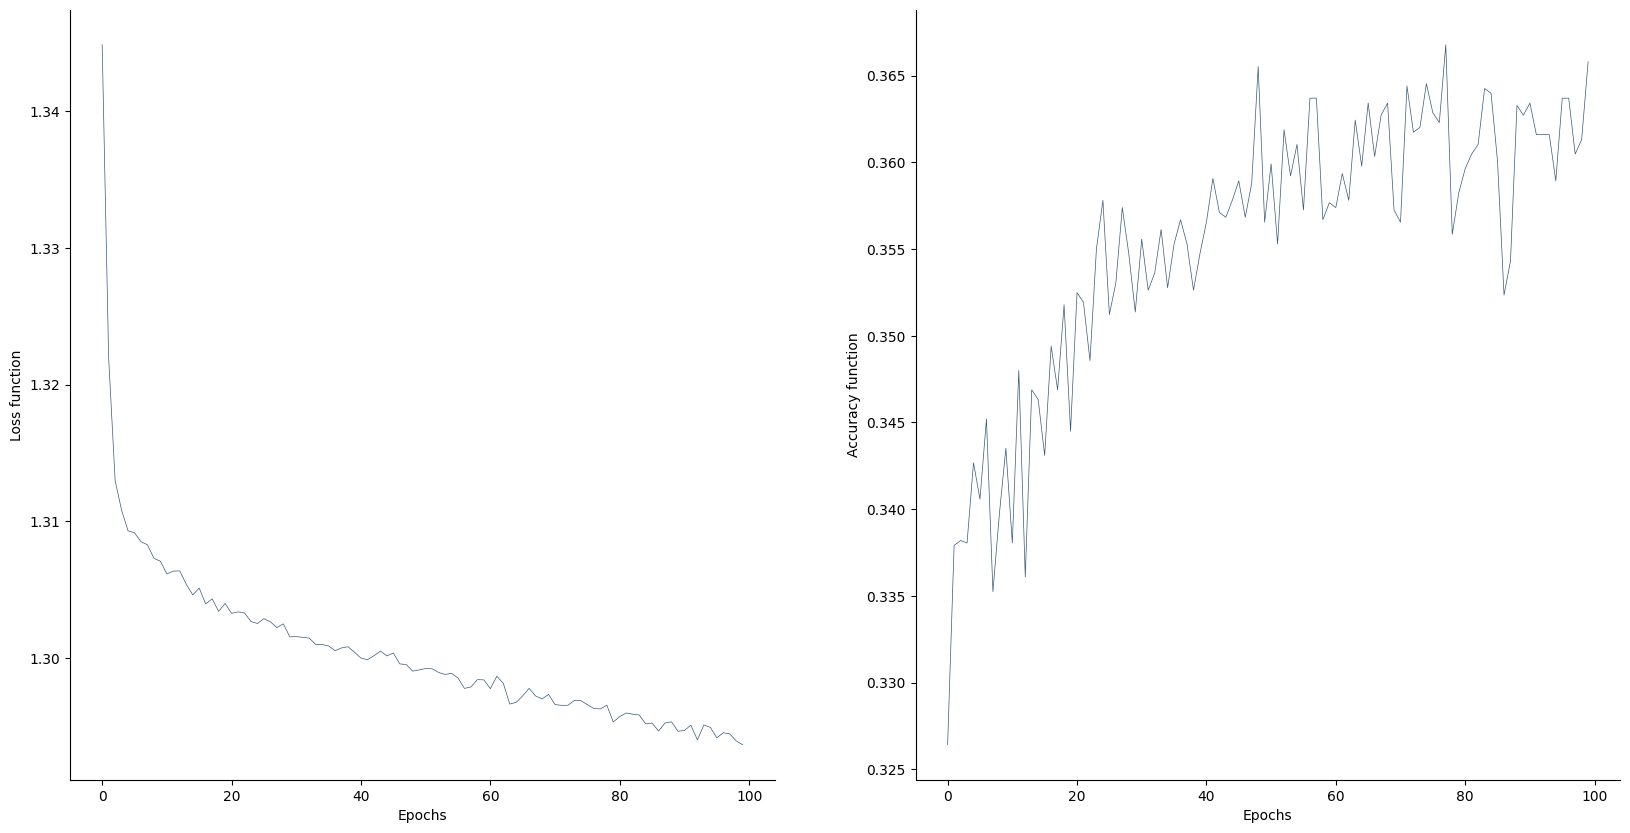

In [187]:
# Neural network training
model_history=model.fit(X_train4, Y_train_dum,epochs=100, batch_size=1, verbose=1)
#%% View the training performance
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(model_history.history['loss'])
plt.xlabel('Epochs'),plt.ylabel('Loss function')
plt.subplot(122)
plt.plot(model_history.history['accuracy'])
plt.xlabel('Epochs'),plt.ylabel('Accuracy function')
#%% Neural network weights
model.layers[0].get_weights()
# model.get_config() #model configuration
#%% View the model
from keras.utils import plot_model
plot_model(model)
# plot_model(model, to_file='../figures/P9_fig/model.png', show_shapes=True)

In [188]:
#%% Use the model
# Latest version
Y_prob = model.predict(X_test4)
Y_pred = np.argmax(Y_prob, axis=1)

56/56 [==============================] - 0s 2ms/step


In [189]:
X_test4

open    volume  quote_asset_volume    trades  \
timestamp                                                               
2022-08-25 19:25:00  0.367938  0.050271            0.046115  0.090827   
2022-08-25 19:30:00  0.368444  0.043676            0.040047  0.084054   
2022-08-25 19:35:00  0.366414  0.044378            0.040678  0.079894   
2022-08-25 19:40:00  0.366298  0.058060            0.053285  0.101601   
2022-08-25 19:45:00  0.374069  0.055364            0.050841  0.097528   
...                       ...       ...                 ...       ...   
2022-08-31 23:35:00  0.079158  0.074156            0.062526  0.085201   
2022-08-31 23:40:00  0.078324  0.104765            0.088474  0.116730   
2022-08-31 23:45:00  0.080534  0.120110            0.101753  0.147120   
2022-08-31 23:50:00  0.085920  0.062607            0.052852  0.066275   
2022-08-31 23:55:00  0.086733  0.055843            0.047115  0.054260   

                     buy_asset_volume  taker_buy_asset_volume  volatility_x  \
timestamp                                                                     
2022-08-25 19:25:00          0.052226                0.047727      0.025407   
2022-08-25 19:30:00          0.042723                0.038984      0.018791   
2022-08-25 19:35:00          0.041274                0.037641      0.012968   
2022-08-25 19:40:00          0.062313                0.057018      0.037923   
2022-08-25 19:45:00          0.047701                0.043615      0.020258   
...                               ...                     ...           ...   
2022-08-31 23:35:00          0.066722                0.056202      0.018638   
2022-08-31 23:40:00          0.109713                0.092707      0.039253   
2022-08-31 23:45:00          0.137276                0.116402      0.046663   
2022-08-31 23:50:00          0.058435                0.049278      0.025962   
2022-08-31 23:55:00          0.055710                0.046975      0.016540   

                     high_open_x  open_low_x  close_open_x  ...  lag_hl_8  \
timestamp                                                   ...             
2022-08-25 19:25:00     0.023139    0.014329      0.604256  ...  0.041905   
2022-08-25 19:30:00     0.008016    0.016961      0.592711  ...  0.016788   
2022-08-25 19:35:00     0.010982    0.009240      0.599695  ...  0.025868   
2022-08-25 19:40:00     0.062927    0.002459      0.636641  ...  0.017785   
2022-08-25 19:45:00     0.002210    0.022025      0.581943  ...  0.028238   
...                          ...         ...           ...  ...       ...   
2022-08-31 23:35:00     0.015543    0.012164      0.597288  ...  0.021375   
2022-08-31 23:40:00     0.031281    0.023319      0.611208  ...  0.045034   
2022-08-31 23:45:00     0.076427    0.002976      0.625734  ...  0.055444   
2022-08-31 23:50:00     0.028567    0.011543      0.604821  ...  0.035357   
2022-08-31 23:55:00     0.024888    0.004279      0.609317  ...  0.041266   

                     lag_vol_8  lag_ol_9  lag_ho_9  lag_hl_9  lag_vol_9  \
timestamp                                                                 
2022-08-25 19:25:00   0.069727  0.010042  0.017124  0.017504   0.045677   
2022-08-25 19:30:00   0.043498  0.042022  0.005302  0.041905   0.069727   
2022-08-25 19:35:00   0.042960  0.012043  0.012703  0.016788   0.043498   
2022-08-25 19:40:00   0.034332  0.003641  0.041228  0.025868   0.042960   
2022-08-25 19:45:00   0.038900  0.005979  0.024175  0.017785   0.034332   
...                        ...       ...       ...       ...        ...   
2022-08-31 23:35:00   0.046321  0.007704  0.027560  0.021554   0.064794   
2022-08-31 23:40:00   0.071272  0.022568  0.003162  0.021375   0.046321   
2022-08-31 23:45:00   0.091805  0.046275  0.003539  0.045034   0.071272   
2022-08-31 23:50:00   0.084758  0.052590  0.010381  0.055444   0.091805   
2022-08-31 23:55:00   0.102516  0.016460  0.036010  0.035357   0.084758   

                     lag_ol_10  lag_ho_10  lag_hl_10  lag_vol_10  
ti

InvalidIndexError: (0, slice(None, None, None))

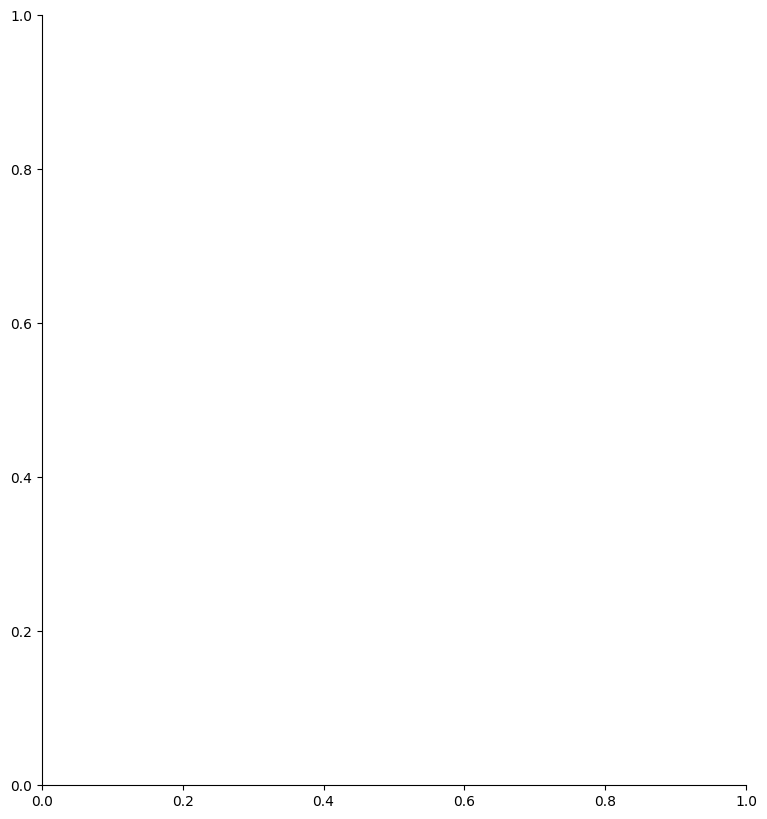

In [190]:
#%% View the neural network prediction
indx = 0
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(np.reshape(X_test4[indx,:],(8,8)),cmap=plt.cm.gray_r)
plt.subplot(122)
plt.bar(np.arange(10),Y_prob[indx,:])
plt.ylim([0,1])
plt.title('Prediction: %d'%np.argmax(Y_prob[indx,:]))

In [191]:
#%% Evaluating the model
score = model.evaluate(X_test4, Y_test_dum,verbose=1)
print(score)

56/56 [==============================] - 0s 1ms/step - loss: 1.2935 - accuracy: 0.3522
[1.2934726476669312, 0.35221537947654724]


In [192]:
#%% More metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score)
Yhat_train = np.argmax(model.predict(X_train4),axis=1)
Yhat_test = np.argmax(model.predict(X_test4),axis=1)
accu_train = accuracy_score(y_train4,Yhat_train)
prec_train = precision_score(y_train4,Yhat_train,average='weighted')
reca_train = recall_score(y_train4,Yhat_train,average='weighted')
accu_test = accuracy_score(y_test4,Yhat_test)
prec_test = precision_score(y_test4,Yhat_test,average='weighted')
reca_test = recall_score(y_test4,Yhat_test,average='weighted')
print(' \t\t Accu \t Prec \t Reca\n Train \t %0.3f \t %0.3f \t %0.3f\n  Test \t %0.3f \t %0.3f \t %0.3f'%(accu_train,prec_train,reca_train,accu_test,prec_test,reca_test))

56/56 [==============================] - 0s 907us/step
 		 Accu 	 Prec 	 Reca
 Train 	 0.206 	 0.135 	 0.206
  Test 	 0.254 	 0.139 	 0.254


C:\Users\Emilio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Emilio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\Emilio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Emilio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Recall is ill-defined and be

# scores

In [193]:
results = {'Accuracy':[accuracy_martingala,accuracy_logistic,accuracy_naive,accuracy_forest],
           'Recall':[recall_martingala,recall_logistic,recall_naive,recall_forest],
           'Precision':[precision_martingala,precision_logistic,precision_naive,precision_forest],
           'F1':[f1_martingala,f1_logistic,f1_naive,f1_forest],
           'Balanced Accuracy':[balanced_martingala,balanced_logistic,balanced_naive,balanced_forest]
          }

table=pd.DataFrame(results,index= ['Martingale','Logistic Regression','Naive Bayes','Random Forest'])
table

Accuracy     Recall  Precision         F1  \
Martingale           28.773268  28.773268  28.773465  28.773366   
Logistic Regression  36.791924  36.791924  36.231506  32.010227   
Naive Bayes          36.174986  36.174986  35.658552  34.703793   
Random Forest        37.072350  37.072350  36.091979  35.752526   

                     Balanced Accuracy  
Martingale                   26.813500  
Logistic Regression          29.669809  
Naive Bayes                  31.659229  
Random Forest                31.588191